In [2]:
import stablerank.srank as sr
from ripser import ripser
import _pickle as pickle
import numpy as np
inf=float("inf")
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial as spatial
import scipy.stats as st
from sklearn import svm
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer
from datetime import timedelta

import time

In [15]:
def circle(c, r, s, error=0):
    t = np.random.uniform(high=2 * np.pi, size=s)
    y = np.sin(t) * r + c[1]
    x = np.cos(t) * r + c[0]
    sd = error * 0.635
    pdf = st.norm(loc=[0, 0], scale=(sd, sd))
    return pdf.rvs((s, 2)) + np.vstack([x, y]).transpose()

def closed_path(vertices, s, error=0):
    v = np.asarray(vertices)
    number_v = len(v)
    l1 = np.linalg.norm(v[1:, :] - v[:-1, :], axis=1)
    _l = np.concatenate([l1, np.array([np.linalg.norm(v[0] - v[-1])])])
    accum_l = np.asarray(list(it.accumulate(_l)))
    t = np.random.uniform(high=accum_l[-1], size=s)
    points = np.empty([0, 2])
    for i in t:
        index = np.searchsorted(accum_l, i)
        coeff = (accum_l[index] - i) / (_l[index])
        if index == number_v - 1:
            points = np.vstack((points, (coeff * v[0] + (1 - coeff) * v[-1])))
        else:
            points = np.vstack((points, (coeff * v[index + 1] + (1 - coeff) * v[index])))
    sd = error * 0.635
    pdf = st.norm(loc=[0, 0], scale=(sd, sd))
    return pdf.rvs((s, 2)) + points

def uniform_noise(x_min, x_max, y_min, y_max, s):
    x = (np.random.random(s) * (x_max - x_min)) + x_min
    y = (np.random.random(s) * (y_max - y_min)) + y_min
    return np.vstack((x, y)).transpose()

## Forming a data set

In [16]:
data = []
i = 0
while i < 100:
    c = circle([0,0], 1, 100, error=0.2)
    data.append(c)
    i += 1  
i = 0
while i < 100:
    s = closed_path([[-0.9,-0.8],[0.8,-1],[0.8,0.7],[-0.7,1]], 100, error=0.2)
    data.append(s)
    i += 1  

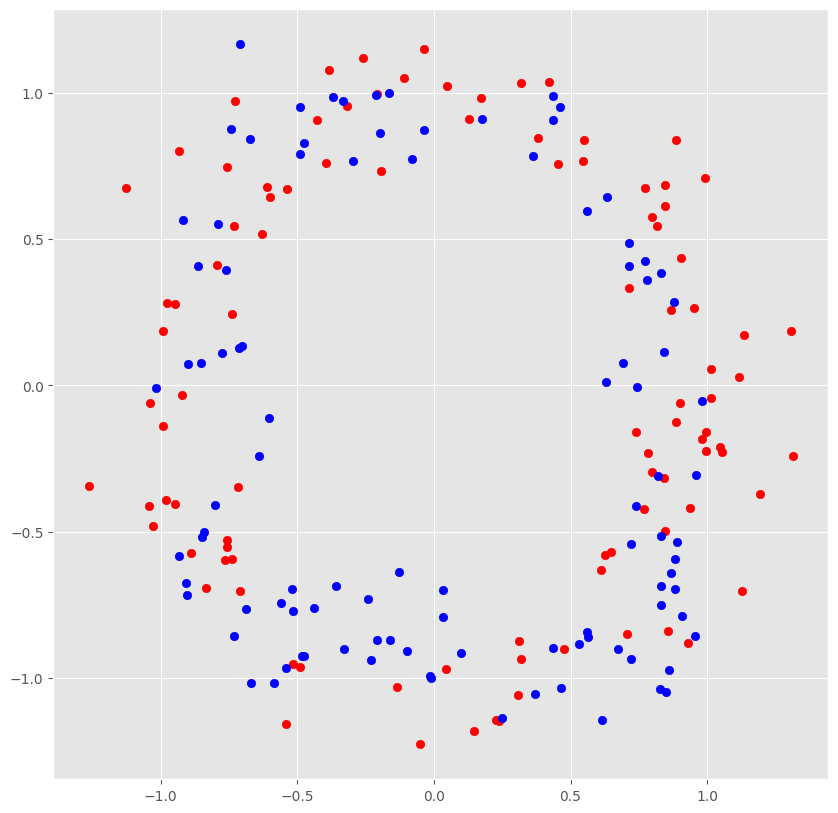

In [33]:
i = 57
j= 156
fig = plt.figure(figsize=(10,10))
plt.scatter(data[i][:,0],data[i][:,1], color="red")
plt.scatter(data[j][:,0],data[j][:,1], color="blue")


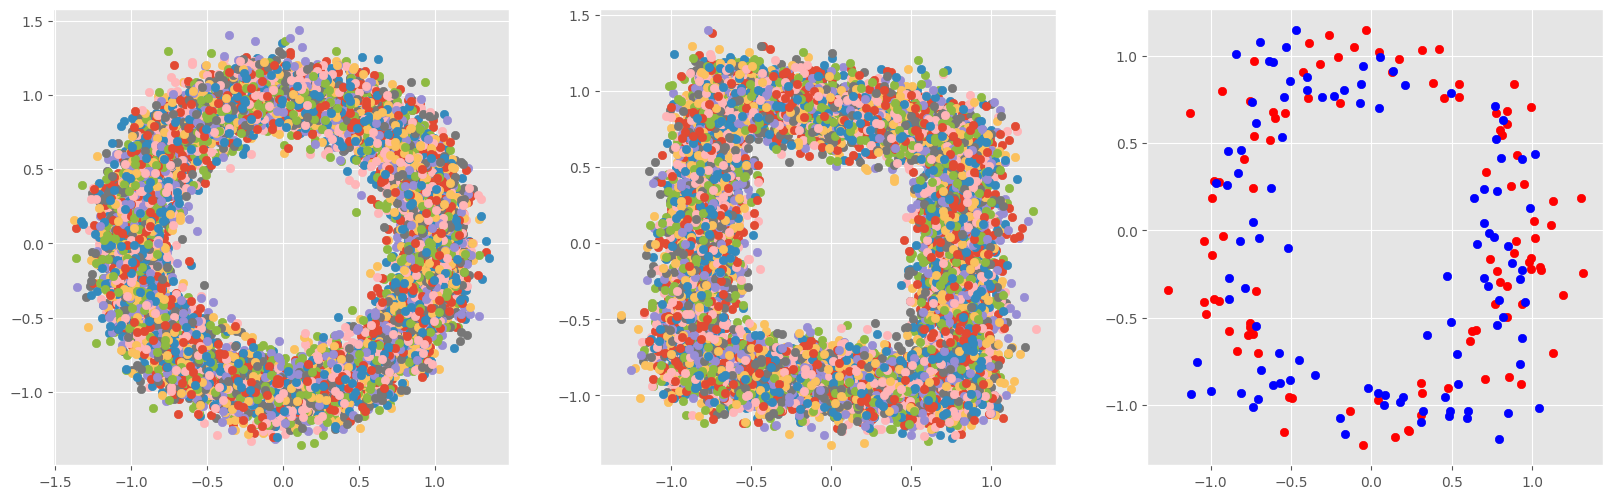

In [34]:
fig = plt.figure(figsize=(20,40))
axes = fig.subplots(1, 3) 
ax_left = axes[0]
ax_left.set_box_aspect(1)
i = 0
while i <100:
    ax_left.scatter(data[i][:,0],data[i][:,1])
    i += 1
    
ax_center = axes[1]
ax_center.set_box_aspect(1)
i = 100
while i <200:
    ax_center.scatter(data[i][:,0],data[i][:,1])
    i += 1

ax_right = axes[2]
ax_right.set_box_aspect(1) 
i = 57
j= 134
ax_right.scatter(data[i][:,0],data[i][:,1], color="red")
ax_right.scatter(data[j][:,0],data[j][:,1], color="blue")


In [19]:
train = []
i = 0
while i < 100:
    c = circle([0,0], 1, 100, error=0.2)
    train.append(c)
    i += 1
i = 0
while i < 100:
    s = closed_path([[-0.9,-0.8],[0.8,-1],[0.8,0.7],[-0.7,1]], 100, error=0.2)
    train.append(s)
    i += 1  
print(len(train))

200


## Fitting SVM

In [20]:
X = [d.flatten() for d in train]

zeros = np.zeros((100,), dtype=int)
ones= np.ones((100,), dtype=int)
y = np.concatenate([zeros,ones])


In [21]:
clf = svm.SVC()
clf.fit(X, y)

test = [d.flatten() for d in data]
pred = clf.predict(test)
a_score = accuracy_score(y, pred)
print(a_score)

0.54


## Extracting H0 stable ranks

In [22]:
# Converitng the data into distance objects
data_dist = [sr.Distance(spatial.distance.pdist(fig, "euclidean")) for fig in data]
train_dist = [sr.Distance(spatial.distance.pdist(fig, "euclidean")) for fig in train]

In [42]:
len(train_dist)

200

In [43]:
# Converitng the distance objects into H0 stable ranks
clustering_methods = ["single", "complete", "average", "ward"]
data_h0sr = {}
train_h0sr = {}
for cm in clustering_methods:
    data_h0sr[cm] = [d.get_h0sr(clustering_method=cm) for d in data_dist]
    train_h0sr[cm] = [d.get_h0sr(clustering_method=cm) for d in train_dist]

In [40]:
len(data_h0sr[cm])

200

## Here is the signal our H0 homology sense produces

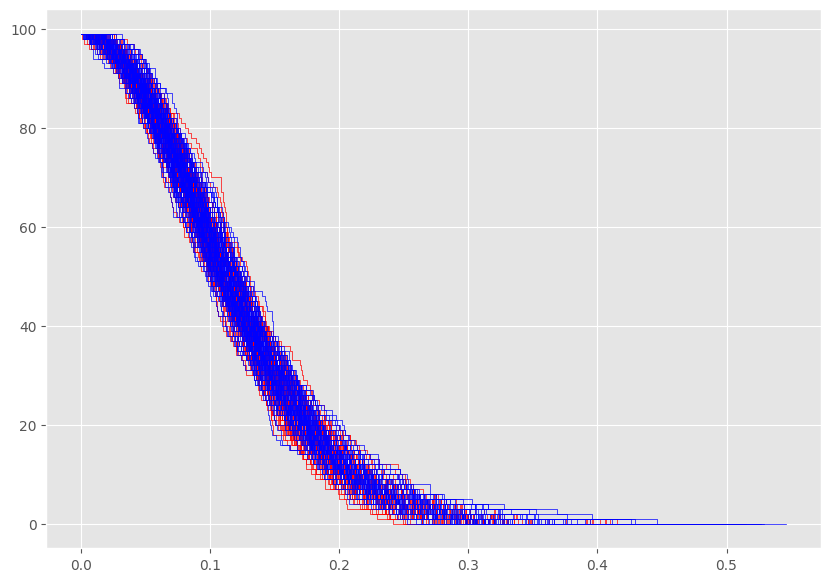

In [25]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h0sr["single"]:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

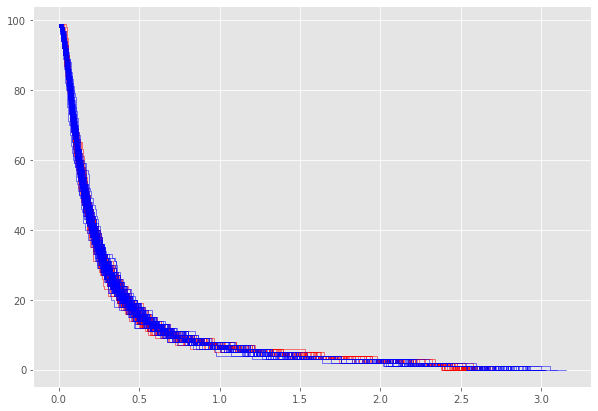

In [12]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h0sr["complete"]:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

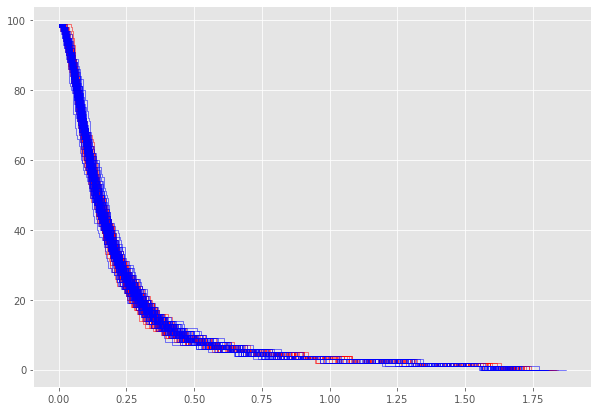

In [13]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h0sr["average"]:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

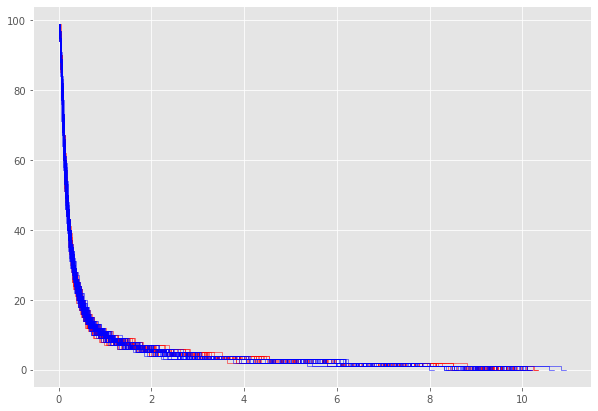

In [14]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h0sr["ward"]:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

## Let us use SVM as a computer inteligance

In [26]:
h0_kernel_train ={ }
h0_kernel_test ={ }
start = timer()    
for cm in clustering_methods:
    h0_kernel_train[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in train_h0sr[cm]])
    h0_kernel_test[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in data_h0sr[cm]])
end = timer()
print(timedelta(seconds=end-start))

0:00:26.913390


In [45]:
len(h0_kernel_train[cm])

200

In [38]:
len(h0_kernel_train['single'])

200

In [46]:
len(y)

200

In [16]:
prediction = {}
a_score = {}
for cm in clustering_methods:
    clf = svm.SVC(kernel='precomputed')
    clf.fit(h0_kernel_train[cm], y)
    prediction[cm] = clf.predict(h0_kernel_test[cm])
    a_score[cm] = accuracy_score(y, prediction[cm])
    print(cm+": ", a_score[cm])

single:  0.46
complete:  0.915
average:  0.825
ward:  0.835


## Let us extract bar codes and higher homology stable ranks

In [17]:
# Converitng the distance objects into bar_codes and stable ranks
data_bc = [d.get_bc(maxdim=1) for d in  data_dist]

data_h1sr = [sr.bc_to_sr(bar_code, degree="H1") for bar_code in data_bc]

train_bc = [d.get_bc(maxdim=1) for d in  train_dist]

train_h1sr = [sr.bc_to_sr(bar_code, degree="H1") for bar_code in train_bc]

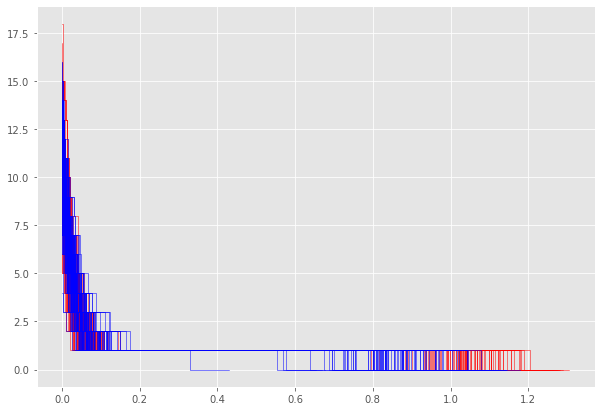

In [18]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h1sr:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

## Let us use SVM as a computer inteligance

In [19]:
start = timer()    

h1_kernel_train = np.asarray([[f.dot(g) for g in train_h1sr] for f in train_h1sr])
h1_kernel_test = np.asarray([[f.dot(g) for g in train_h1sr] for f in data_h1sr])

end = timer()
print(timedelta(seconds=end-start))

0:00:13.057925


In [20]:
zeros = np.zeros((100,), dtype=int)
ones= np.ones((100,), dtype=int)
y = np.concatenate([zeros,ones])


clf = svm.SVC(kernel='precomputed')
clf.fit(h1_kernel_train, y)
prediction = clf.predict(h1_kernel_test)
a_score = accuracy_score(y, prediction)

In [21]:
print(a_score)

0.85


# The case of noisy to data

In [99]:

data = []
data_noise_level =[]
i = 0
while i < 100:
    n = np.random.randint(10, 25)
    data_noise_level.append(n)
    c = circle([0,0], 1, 100-n, error=0.2)
    noise = uniform_noise(-1.5, 1.5, -1.5, 1.5, n)
    fig = np.concatenate([c,noise], axis=0)
    data.append(fig)
    i += 1  
i = 0
while i < 100:
    n = np.random.randint(10, 25)
    data_noise_level.append(n)
    #t = closed_path([[-0.9,-0.8],[1.2,-0.2],[-0.2,1.2]], 100-n, error=0.2)
    t = closed_path([[-0.9,-0.8],[0.8,-1],[0.8,0.7],[-0.7,1]], 100-n, error=0.2)
    noise = uniform_noise(-1.5, 1.5, -1.5, 1.5, n)
    fig = np.concatenate([t,noise], axis=0)
    data.append(fig)
    i += 1  

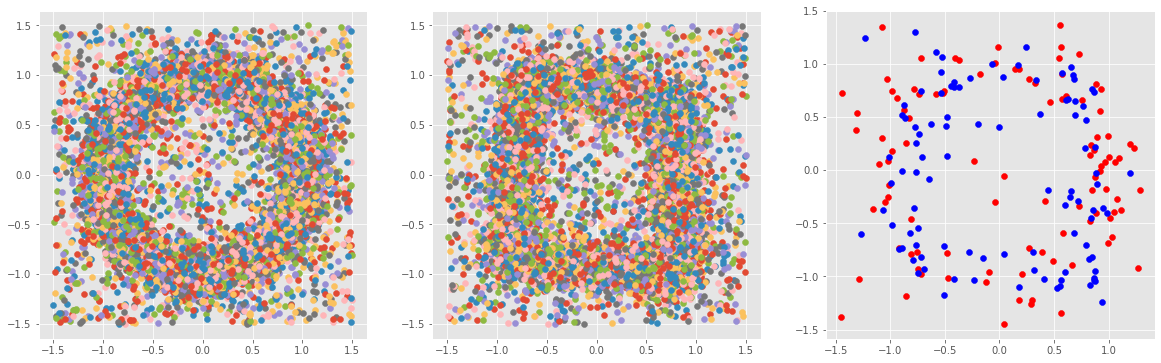

In [100]:
fig = plt.figure(figsize=(20,40))
axes = fig.subplots(1, 3) 
ax_left = axes[0]
ax_left.set_box_aspect(1)
i = 0
while i <100:
    ax_left.scatter(data[i][:,0],data[i][:,1])
    i += 1
    
ax_center = axes[1]
ax_center.set_box_aspect(1)
i = 100
while i <200:
    ax_center.scatter(data[i][:,0],data[i][:,1])
    i += 1

ax_right = axes[2]
ax_right.set_box_aspect(1) 
i = 57
j= 134
ax_right.scatter(data[i][:,0],data[i][:,1], color="red")
ax_right.scatter(data[j][:,0],data[j][:,1], color="blue")


In [101]:

train = []
train_noise_level =[]
i = 0
while i < 100:
    n = np.random.randint(10, 25)
    train_noise_level.append(n)
    c = circle([0,0], 1, 100-n, error=0.2)
    noise = uniform_noise(-1.5, 1.5, -1.5, 1.5, n)
    fig = np.concatenate([c,noise], axis=0)
    train.append(fig)
    i += 1  
i = 0
while i < 100:
    n = np.random.randint(10, 25)
    train_noise_level.append(n)
    #t = closed_path([[-0.9,-0.8],[1.2,-0.2],[-0.2,1.2]], 100-n, error=0.2)
    t = closed_path([[-0.9,-0.8],[0.8,-1],[0.8,0.7],[-0.7,1]], 100-n, error=0.2)
    noise = uniform_noise(-1.5, 1.5, -1.5, 1.5, n)
    fig = np.concatenate([t,noise], axis=0)
    train.append(fig)
    i += 1  

14
11


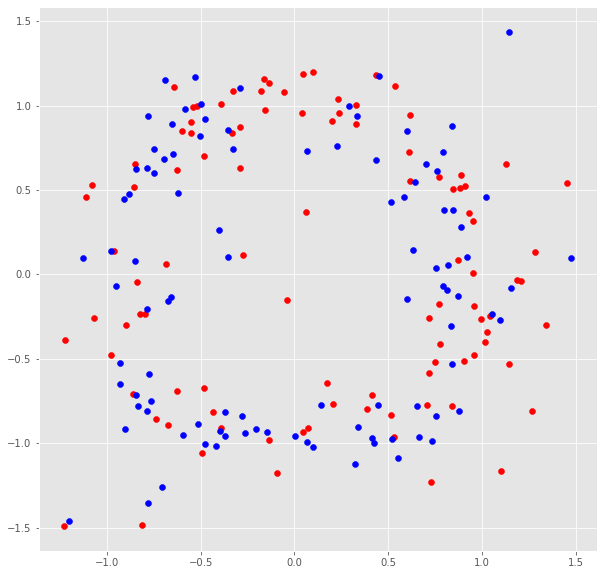

In [102]:
i = 59
print(data_noise_level[i])
j= 156
print(data_noise_level[j])
fig = plt.figure(figsize=(10,10))
plt.scatter(data[i][:,0],data[i][:,1], color="red")
plt.scatter(data[j][:,0],data[j][:,1], color="blue")


## Extracting H0 stable ranks

In [103]:
# Converitng the data into distance objects
data_dist = [sr.Distance(spatial.distance.pdist(fig, "euclidean")) for fig in data]
train_dist = [sr.Distance(spatial.distance.pdist(fig, "euclidean")) for fig in train]

In [104]:
# Converitng the distance objects into H0 stable ranks
clustering_methods = ["single", "complete", "average", "ward"]
data_h0sr = {}
train_h0sr = {}
for cm in clustering_methods:
    data_h0sr[cm] = [d.get_h0sr(clustering_method=cm) for d in data_dist]
    train_h0sr[cm] = [d.get_h0sr(clustering_method=cm) for d in train_dist]

## Here is the signal our H0 homology sense produces

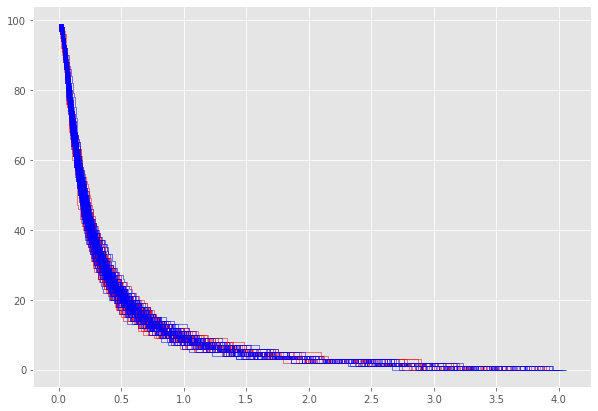

In [105]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h0sr["complete"]:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

In [106]:
h0_kernel_train ={ }
h0_kernel_test ={ }
start = timer()    
for cm in clustering_methods:
    h0_kernel_train[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in train_h0sr[cm]])
    h0_kernel_test[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in data_h0sr[cm]])
end = timer()
print(timedelta(seconds=end-start))

0:01:03.860088


In [107]:
prediction = {}
a_score = {}
for cm in clustering_methods:
    clf = svm.SVC(kernel='precomputed')
    clf.fit(h0_kernel_train[cm], y)
    prediction[cm] = clf.predict(h0_kernel_test[cm])
    a_score[cm] = accuracy_score(y, prediction[cm])
    print(cm+": ", a_score[cm])

single:  0.54
complete:  0.575
average:  0.61
ward:  0.66


## Let us try with 1st homology

In [108]:
# Converitng the distance objects into bar_codes and stable ranks
data_bc = [d.get_bc(maxdim=1) for d in  data_dist]

data_h1sr = [sr.bc_to_sr(bar_code, degree="H1") for bar_code in data_bc]

train_bc = [d.get_bc(maxdim=1) for d in  train_dist]

train_h1sr = [sr.bc_to_sr(bar_code, degree="H1") for bar_code in train_bc]

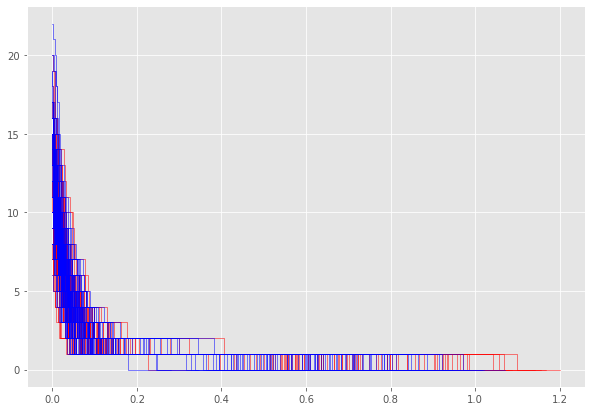

In [109]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h1sr:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

In [110]:
start = timer()    

h1_kernel_train = np.asarray([[f.dot(g) for g in train_h1sr] for f in train_h1sr])
h1_kernel_test = np.asarray([[f.dot(g) for g in train_h1sr] for f in data_h1sr])

end = timer()
print(timedelta(seconds=end-start))

0:00:13.680203


In [111]:
zeros = np.zeros((100,), dtype=int)
ones= np.ones((100,), dtype=int)
y = np.concatenate([zeros,ones])


clf = svm.SVC(kernel='precomputed')
clf.fit(h1_kernel_train, y)
prediction = clf.predict(h1_kernel_test)
a_score = accuracy_score(y, prediction)

In [112]:
print(a_score)

0.58


## Need to lower deviation!!!!!!!

In [36]:
number_instances = 7
sample_size = 5
n = 18
s = sr.get_sample(number_instances, sample_size, n)
print(s)
print(s.sample)

[[ 1  3  5  9 12]
 [ 0  1 10 12 15]
 [ 6 11 12 14 16]
 [ 4  5  6 11 16]
 [ 3  4  9 11 12]
 [ 2  6 10 13 14]
 [ 1  6 11 13 16]]


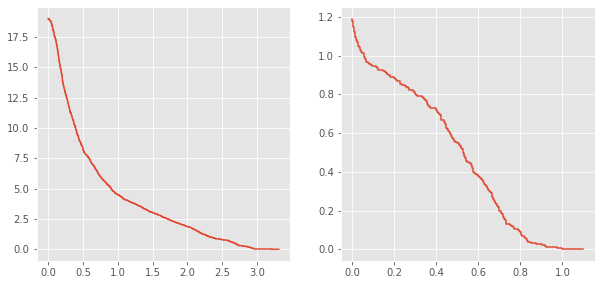

In [37]:
number_instances = 200
sample_size = 20

c = data[3]

d = spatial.distance.pdist(c, "euclidean")

# getting a distance object
c_dist = sr.Distance(d)


s = sr.get_sample(number_instances, sample_size, c_dist.size())

f = c_dist.get_h0sr(sample=s, clustering_method="complete")

b = c_dist.get_bc(sample=s)

g = sr.bc_to_sr(b, degree="H1")


fig = plt.figure(figsize=(10,20))
axes = fig.subplots(1, 2) 
ax_left = axes[0]
ax_left.set_box_aspect(1)
f.plot(ax=ax_left)

ax_right = axes[1]
ax_right.set_box_aspect(1)
g.plot(ax=ax_right)

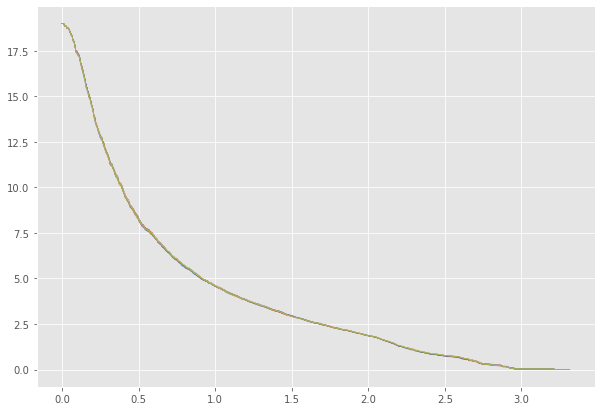

In [38]:
number_instances = 1000
sample_size = 20
fig = plt.figure(figsize=(10,7))
i = 0
while i <20:
    s = sr.get_sample(number_instances, sample_size, c_dist.size())
    f = c_dist.get_h0sr(sample=s, clustering_method="complete")
    f.plot(linewidth=0.5)
    i += 1

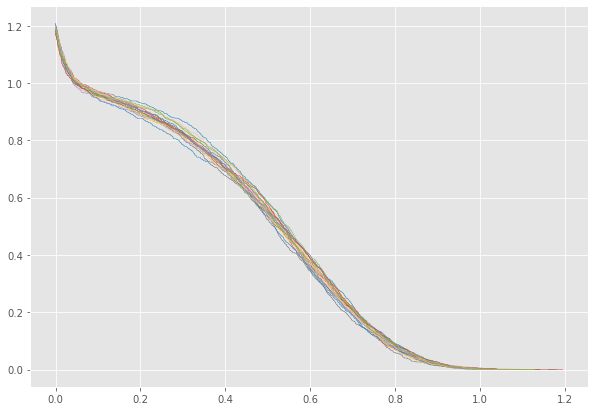

In [39]:
number_instances = 1000
sample_size = 20
fig = plt.figure(figsize=(10,7))
i = 0
while i <20:
    s = sr.get_sample(number_instances, sample_size, c_dist.size())
    b = c_dist.get_bc(sample=s, maxdim=1)
    f = sr.bc_to_sr(b, degree="H1")
    f.plot(linewidth=0.5)
    i += 1

## Extrating averaged H0 stable ranks

In [113]:
# Converitng the distance objects into H0 stable ranks
number_instances = 300
sample_size = 20

clustering_methods = ["single", "complete", "average", "ward"]
data_h0sr = {}
train_h0sr = {}
start = timer()    
for cm in clustering_methods:
    data_h0sr[cm] = []
    train_h0sr[cm] = []
    for d in  data_dist:
        s = sr.get_sample(number_instances, sample_size, d.size())
        f = d.get_h0sr(sample=s, clustering_method=cm)
        data_h0sr[cm].append(f)
    for d in train_dist:
        s = sr.get_sample(number_instances, sample_size,  d.size())
        g = d.get_h0sr(sample=s, clustering_method=cm)
        train_h0sr[cm].append(g)
end = timer()
print(timedelta(seconds=end-start))

0:03:44.985425


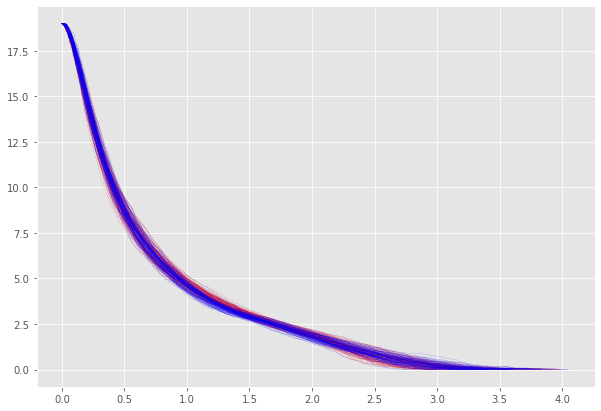

In [114]:
plt.figure(figsize=(10,7))
i = 0
for f in data_h0sr["complete"]:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.1)
    i += 1

In [115]:
h0_kernel_train ={ }
h0_kernel_test ={ }
start = timer()    
for cm in clustering_methods:
    h0_kernel_train[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in train_h0sr[cm]])
    h0_kernel_test[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in data_h0sr[cm]])
end = timer()
print(timedelta(seconds=end-start))

0:05:43.480595


In [116]:
prediction = {}
a_score = {}
for cm in clustering_methods:
    clf = svm.SVC(kernel='precomputed')
    clf.fit(h0_kernel_train[cm], y)
    prediction[cm] = clf.predict(h0_kernel_test[cm])
    a_score[cm] = accuracy_score(y, prediction[cm])
    print(cm+": ", a_score[cm])

single:  0.615
complete:  0.875
average:  0.71
ward:  0.75


## Extrating averaged H1 stable ranks

In [44]:
# Converitng the distance objects into H0 stable ranks
number_instances = 400
sample_size = 20

data_h1sr = []
train_h1sr = []
start = timer()  
for d in  data_dist:
    s = sr.get_sample(number_instances, sample_size, d.size())
    b = d.get_bc(sample=s, maxdim=1)
    f = sr.bc_to_sr(b, degree="H1")
    data_h1sr.append(f)
for d in train_dist:
    s = sr.get_sample(number_instances, sample_size,  d.size())
    b = d.get_bc(sample=s, maxdim=1)
    f = sr.bc_to_sr(b, degree="H1")
    train_h1sr.append(f)
end = timer()
print(timedelta(seconds=end-start))

0:00:52.713699


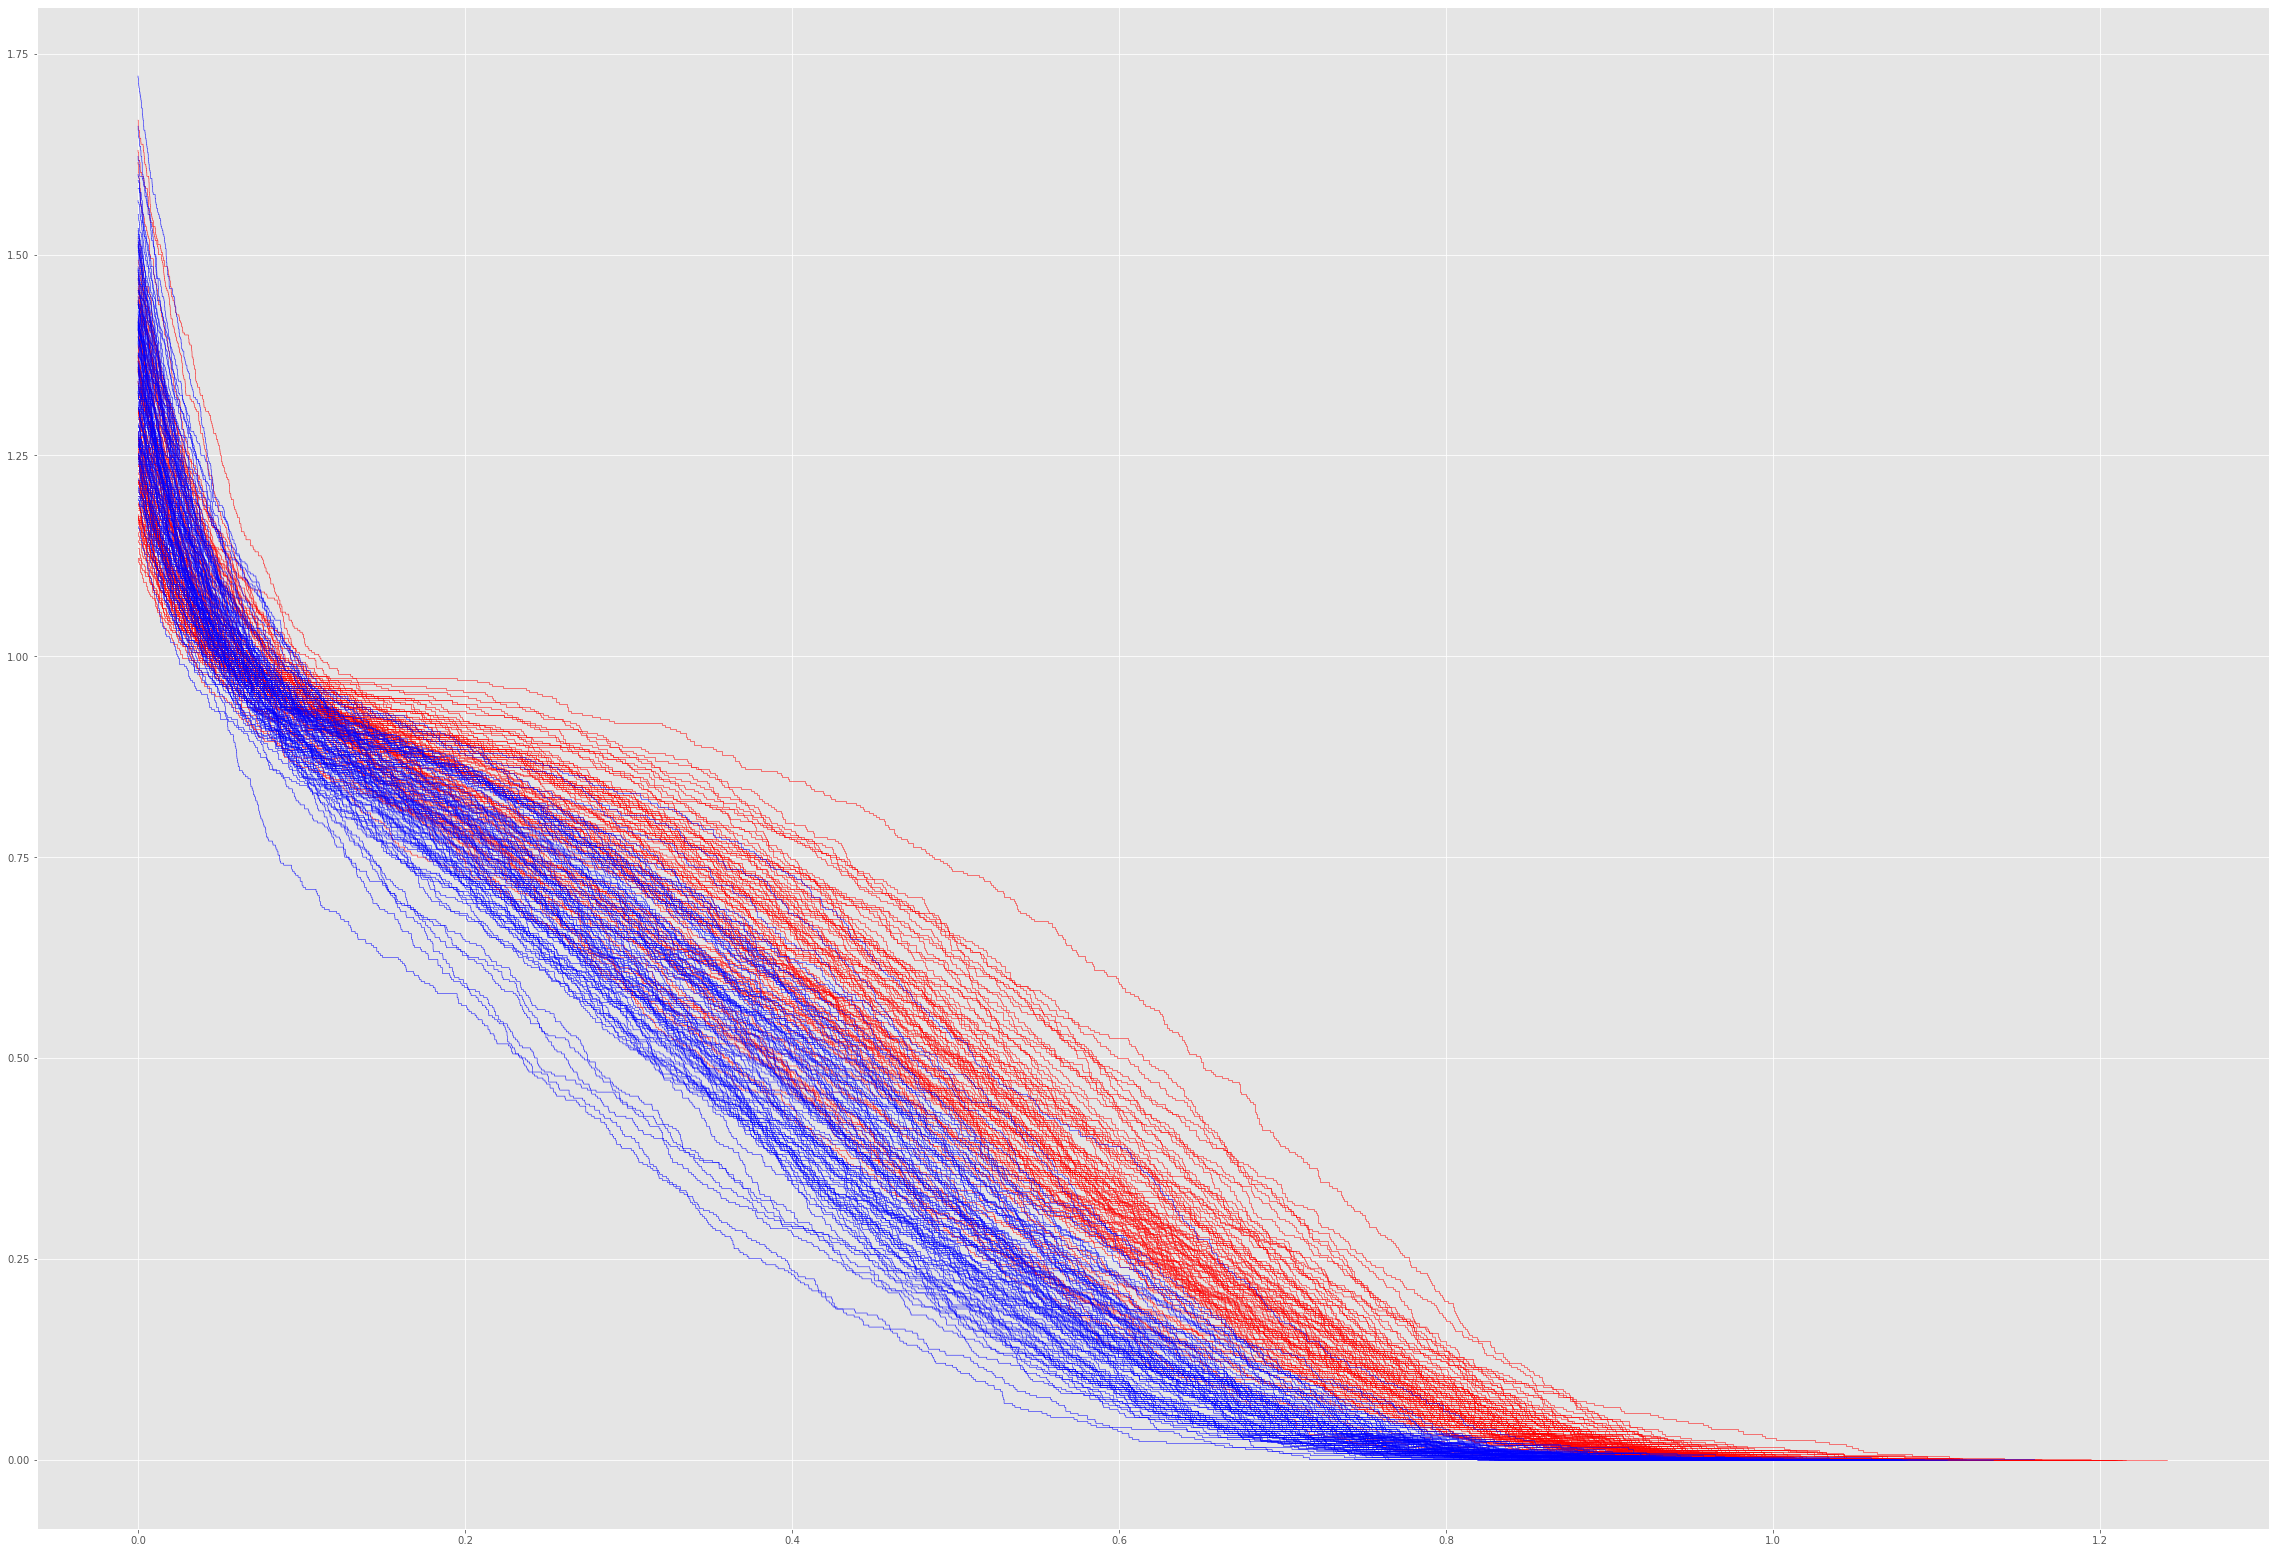

In [45]:
plt.figure(figsize=(40,28))
i = 0
for f in data_h1sr:
    if i <100:
        color = "red"
    else:
        color = "blue"
    f.plot(color=color, linewidth=0.5)
    i += 1

In [46]:
start = timer()    
h1_kernel_train = np.asarray([[f.dot(g) for g in train_h1sr] for f in train_h1sr])
h1_kernel_test = np.asarray([[f.dot(g) for g in train_h1sr] for f in data_h1sr])
end = timer()
print(timedelta(seconds=end-start))

0:00:25.117090


In [47]:
clf = svm.SVC(kernel='precomputed')
clf.fit(h1_kernel_train, y)
prediction = clf.predict(h1_kernel_test)
a_score = accuracy_score(y, prediction)
print(a_score)

0.85


## Wisconsin breast cancer

In [4]:
org_input = pd.read_csv("Data/breast-cancer-wisconsin.csv", sep=",", header=None).to_numpy()
input = np.empty(org_input.shape, dtype="double")
a = 0
j = 0
i = 0
while i < len(org_input):
    if org_input[i,5]!="?":
        j += 1
        a += np.double(org_input[i,5])
    i += 1
avg = a/j     
for i,x in np.ndenumerate(org_input):
    if x=="?":
        input[i]= avg
    else:
        input[i]= np.double(x)

data = input[:,:9]
classification = input[:,9]

In [5]:
print("number of patients: ", len(classification))
print("number of benign cases (class 2): ", len(np.where(classification==2)[0]))
print("number of malignant cases (class 4): ", len(np.where(classification==4)[0]))

number of patients:  699
number of benign cases (class 2):  458
number of malignant cases (class 4):  241


In [6]:
print("number of data points: ", len(classification))

number of data points:  699


In [7]:
print(len([i for i in range(len(classification)) if classification[i]==2]))

458


In [8]:
distance = sr.Distance(spatial.distance.pdist(data, "euclidean"))

In [9]:
wisconsin_distances = distance.square_form()

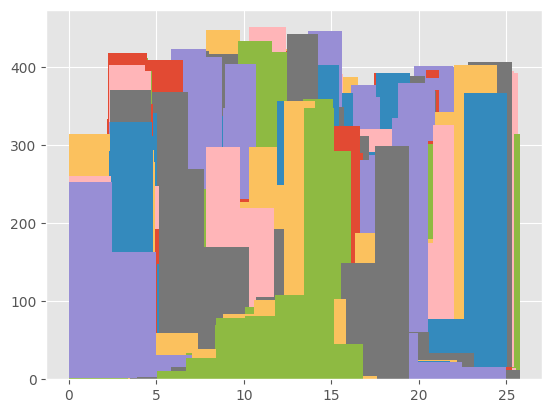

In [10]:
i = 0
while i < len(wisconsin_distances):
    plt.hist(wisconsin_distances[i])
    i += 1

In [11]:
distributions = {}
distributions["0_15"] = sr.get_distribution(name="uniform", interval=[0,15])
distributions["5_20"] = sr.get_distribution(name="uniform", interval=[5,20])
distributions["10_25"] = sr.get_distribution(name="uniform", interval=[10,25])
distributions["10_30"] = sr.get_distribution(name="uniform", interval=[10,30])
distributions["15_30"] = sr.get_distribution(name="uniform", interval=[15,30])

In [12]:
probabilities = {}
for k in distributions.keys():
    probabilities[k] = distributions[k](wisconsin_distances)

In [14]:
number_instances=300
sample_size=30

start = timer()    
h0_sr = {}
h1_sr = {}
for k in  distributions.keys():
    h0_sr[k] = []
    h1_sr[k] = []
    for patient in wisconsin_distances[0:1]:
        p = distributions[k](patient)
        s = sr.get_sample(number_instances, sample_size, p)
        f = distance.get_h0sr(sample=s,clustering_method="complete")
        b = distance.get_bc(sample=s, maxdim=1)
        g = sr.bc_to_sr(b,degree="H1")
        h0_sr[k].append(f)
        h1_sr[k].append(g)
end = timer()
print(timedelta(seconds=end-start))                      

0:00:00.800178


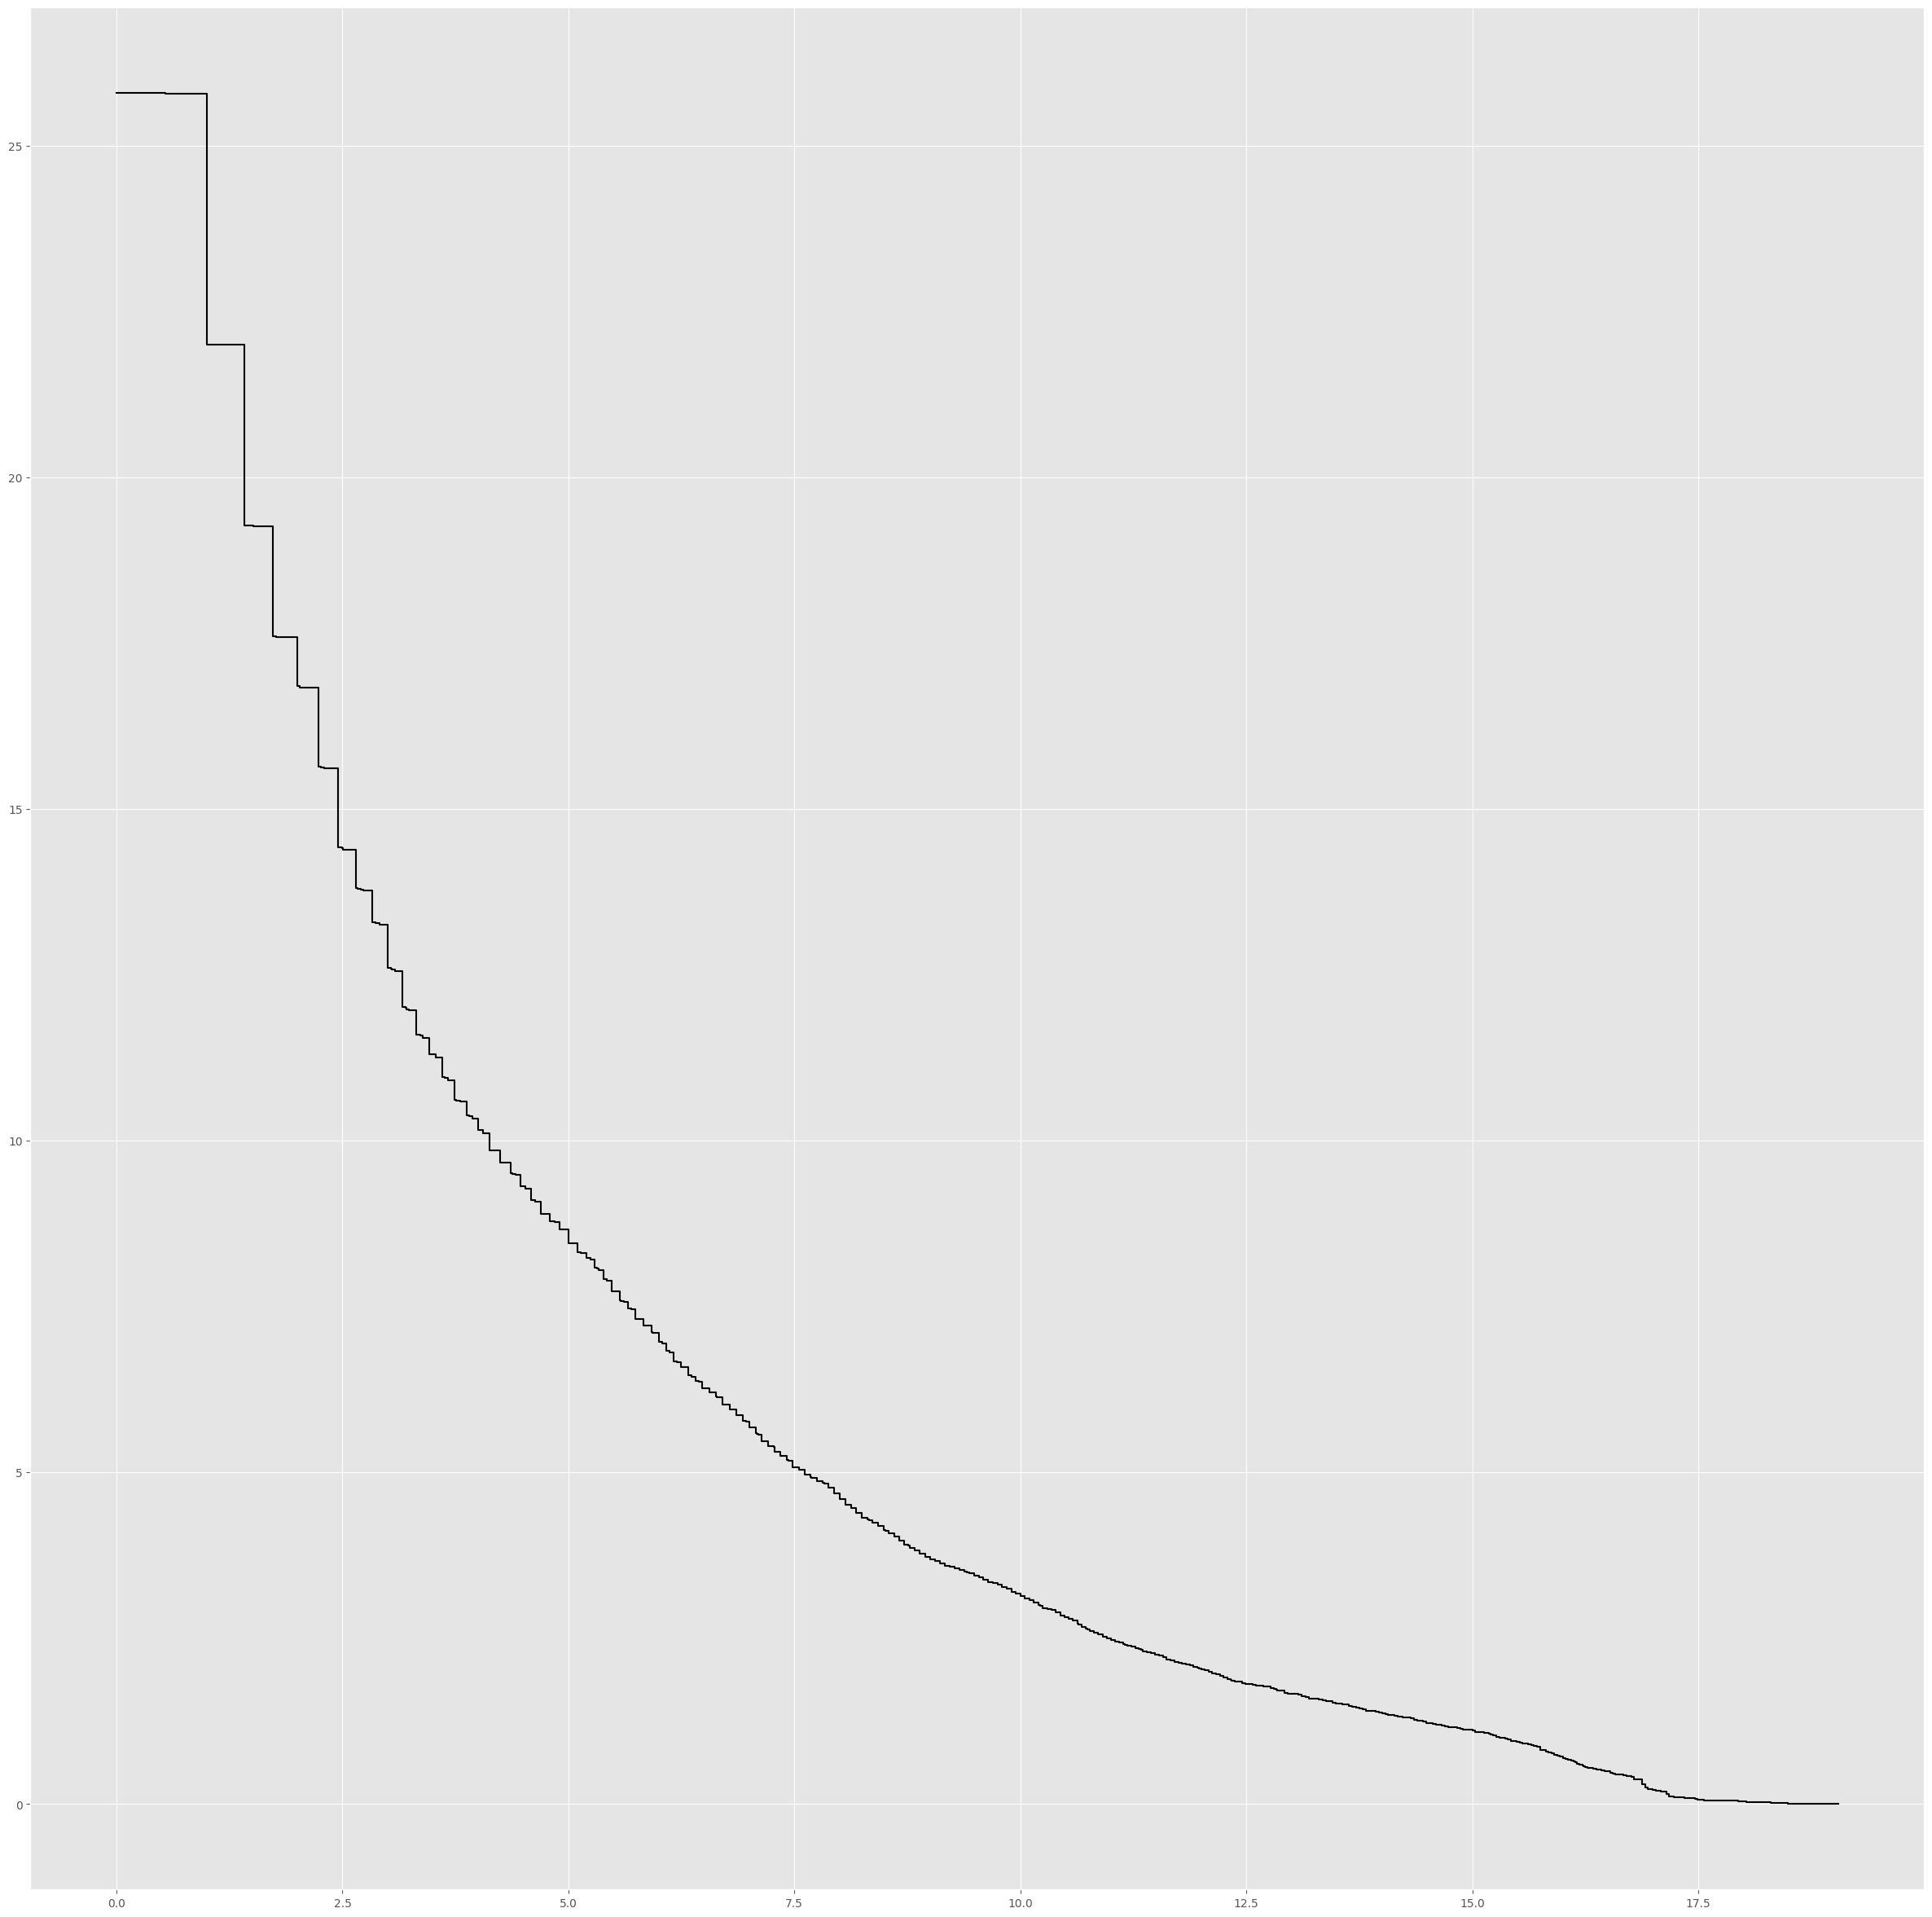

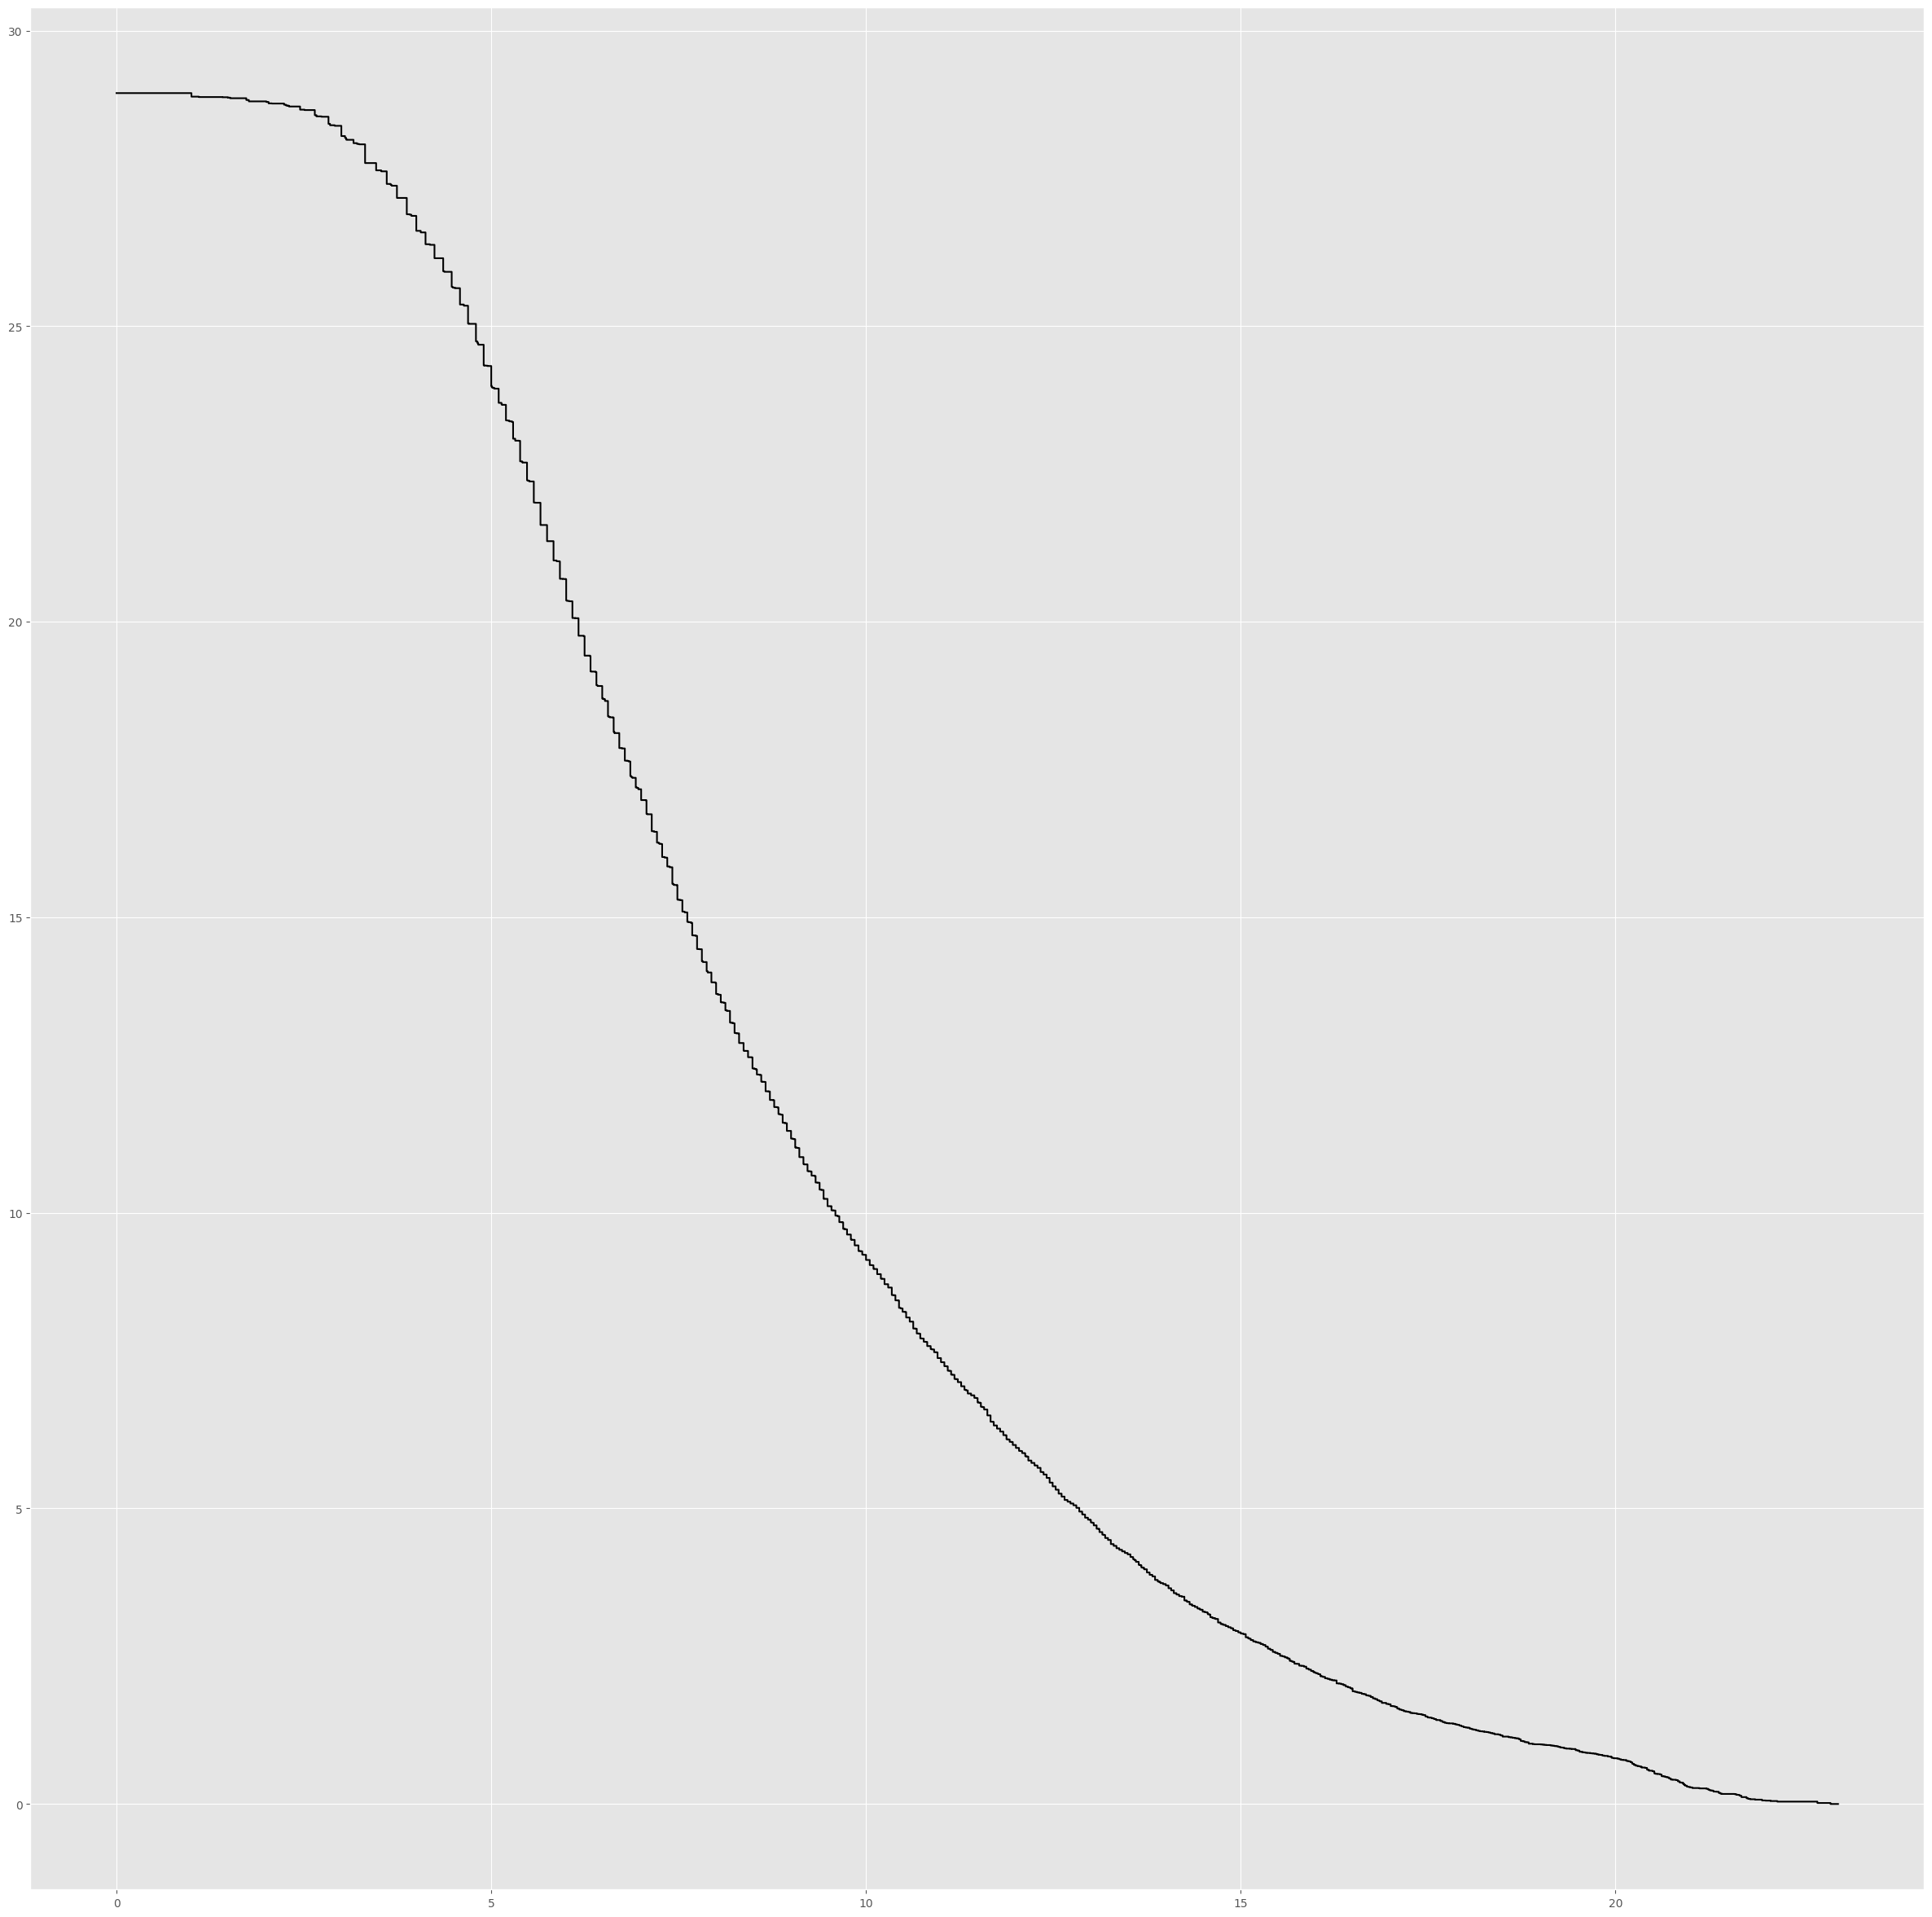

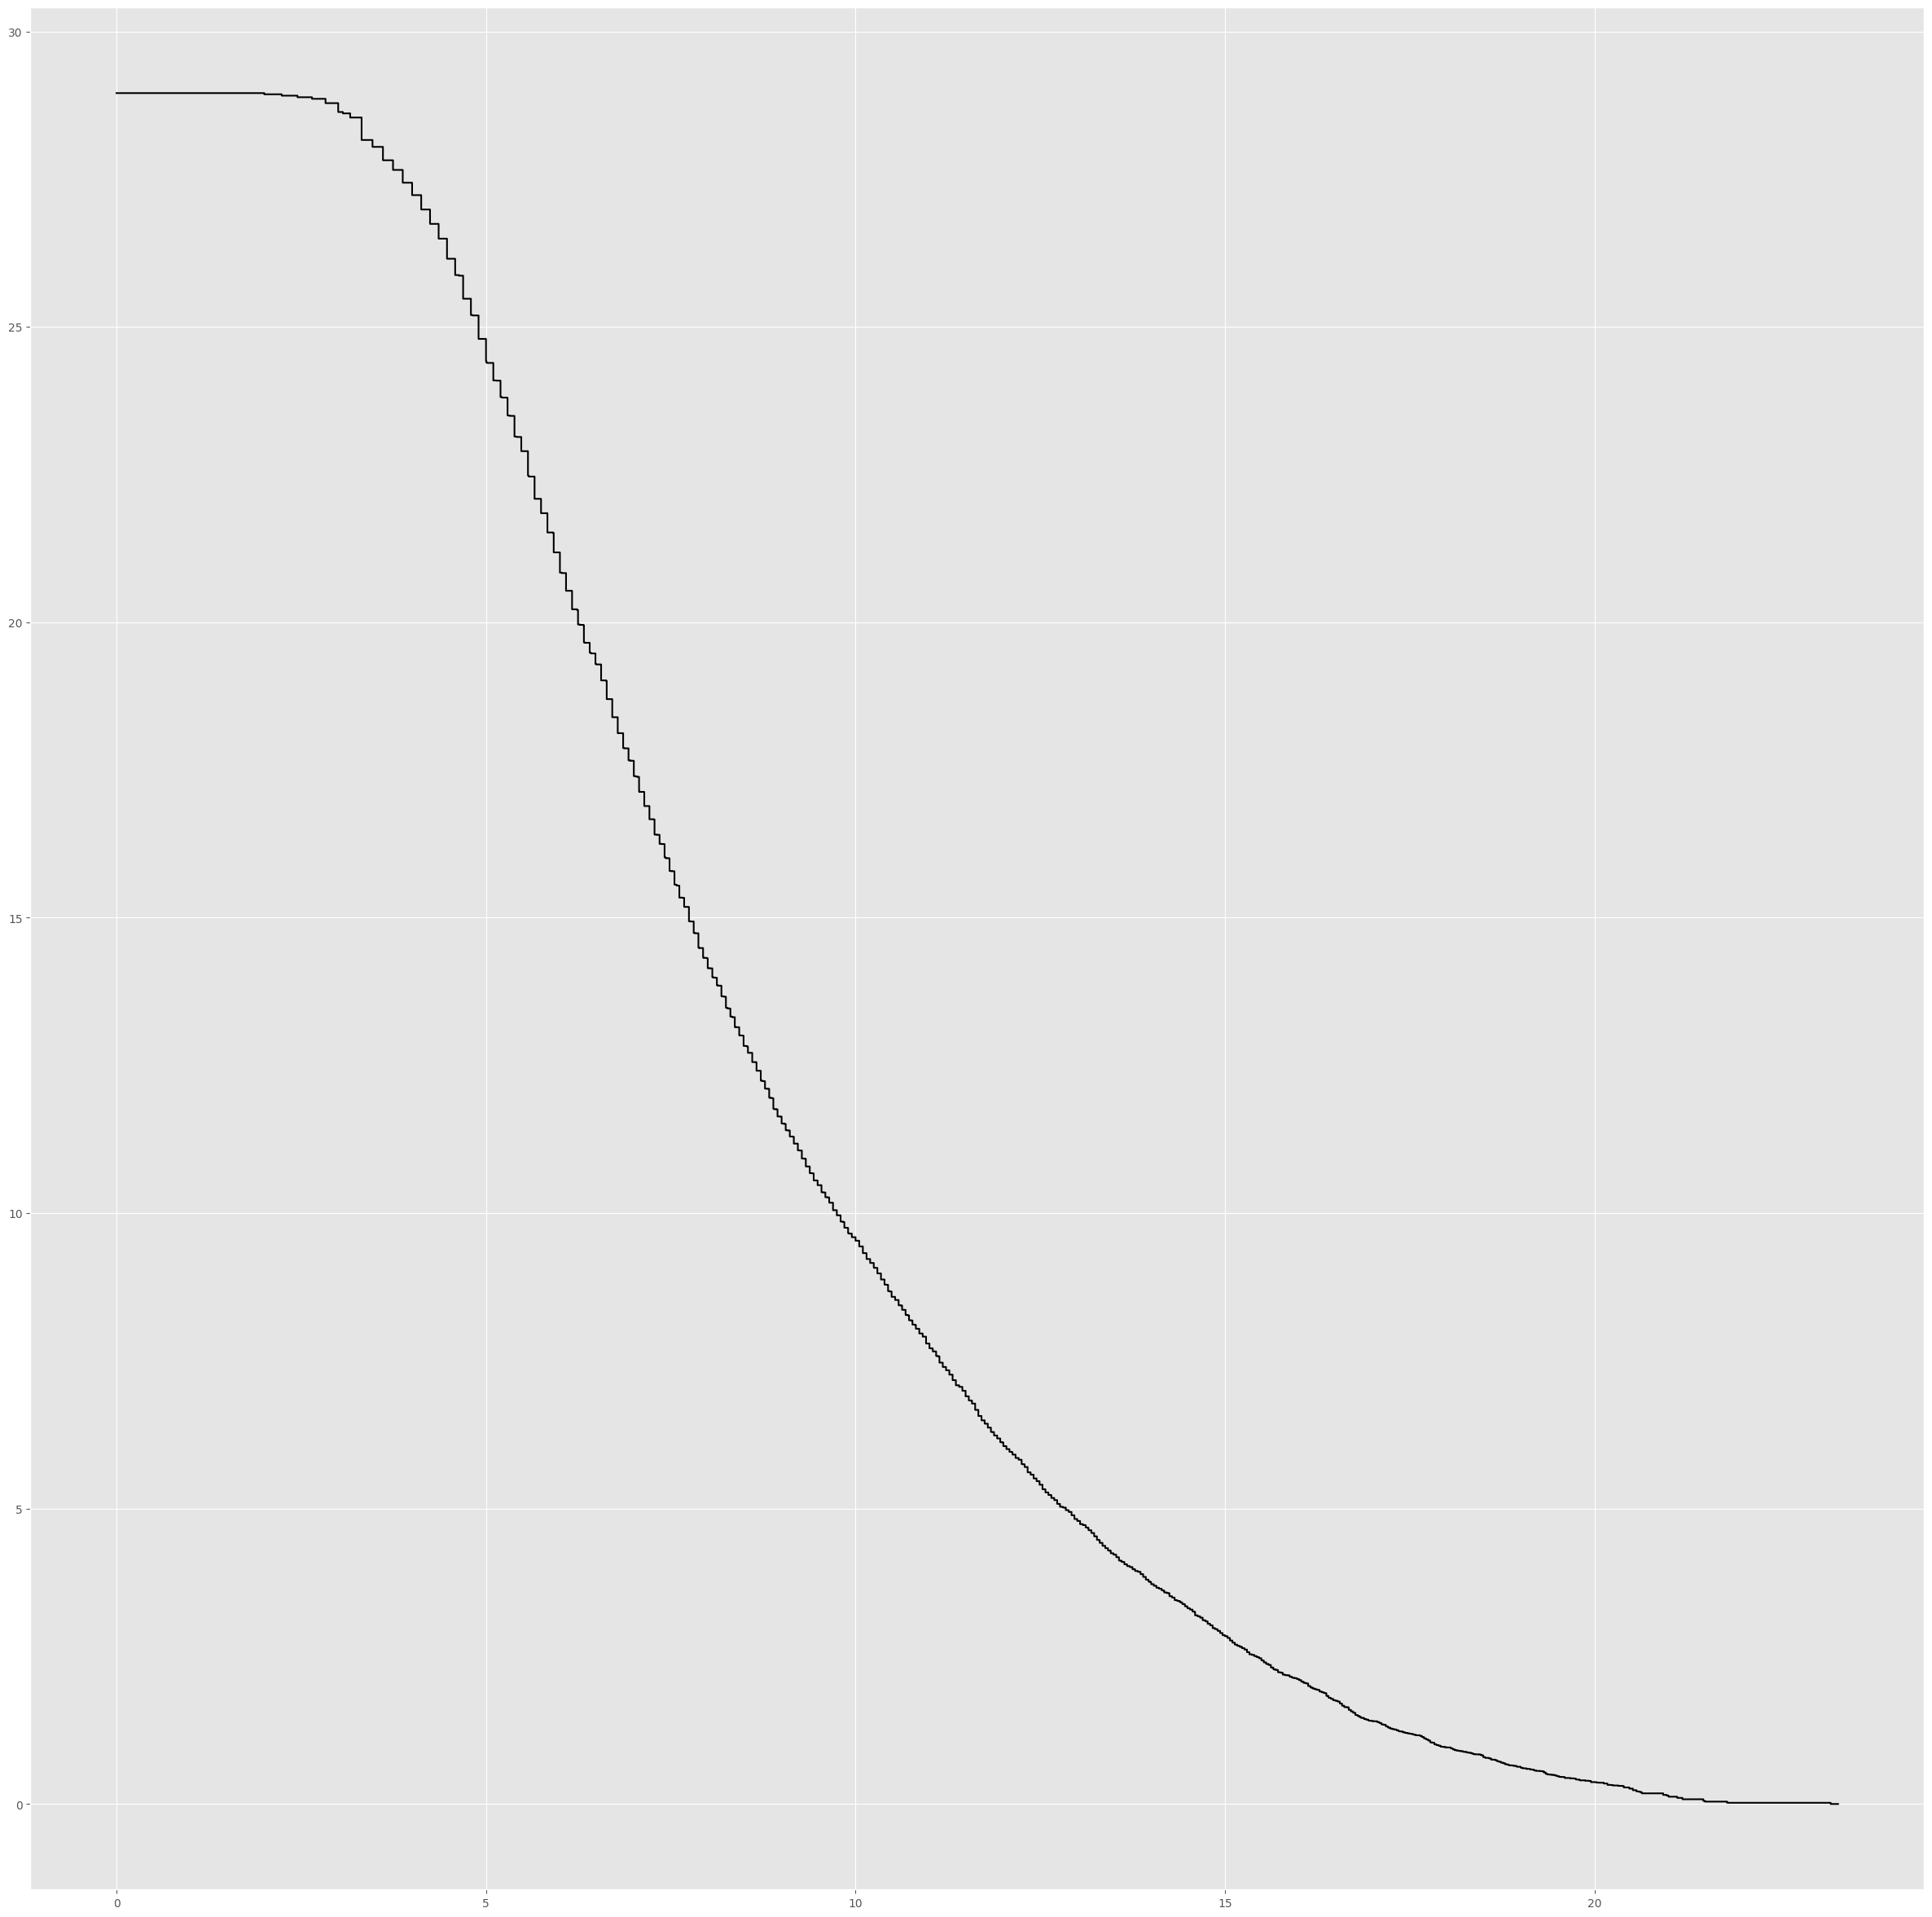

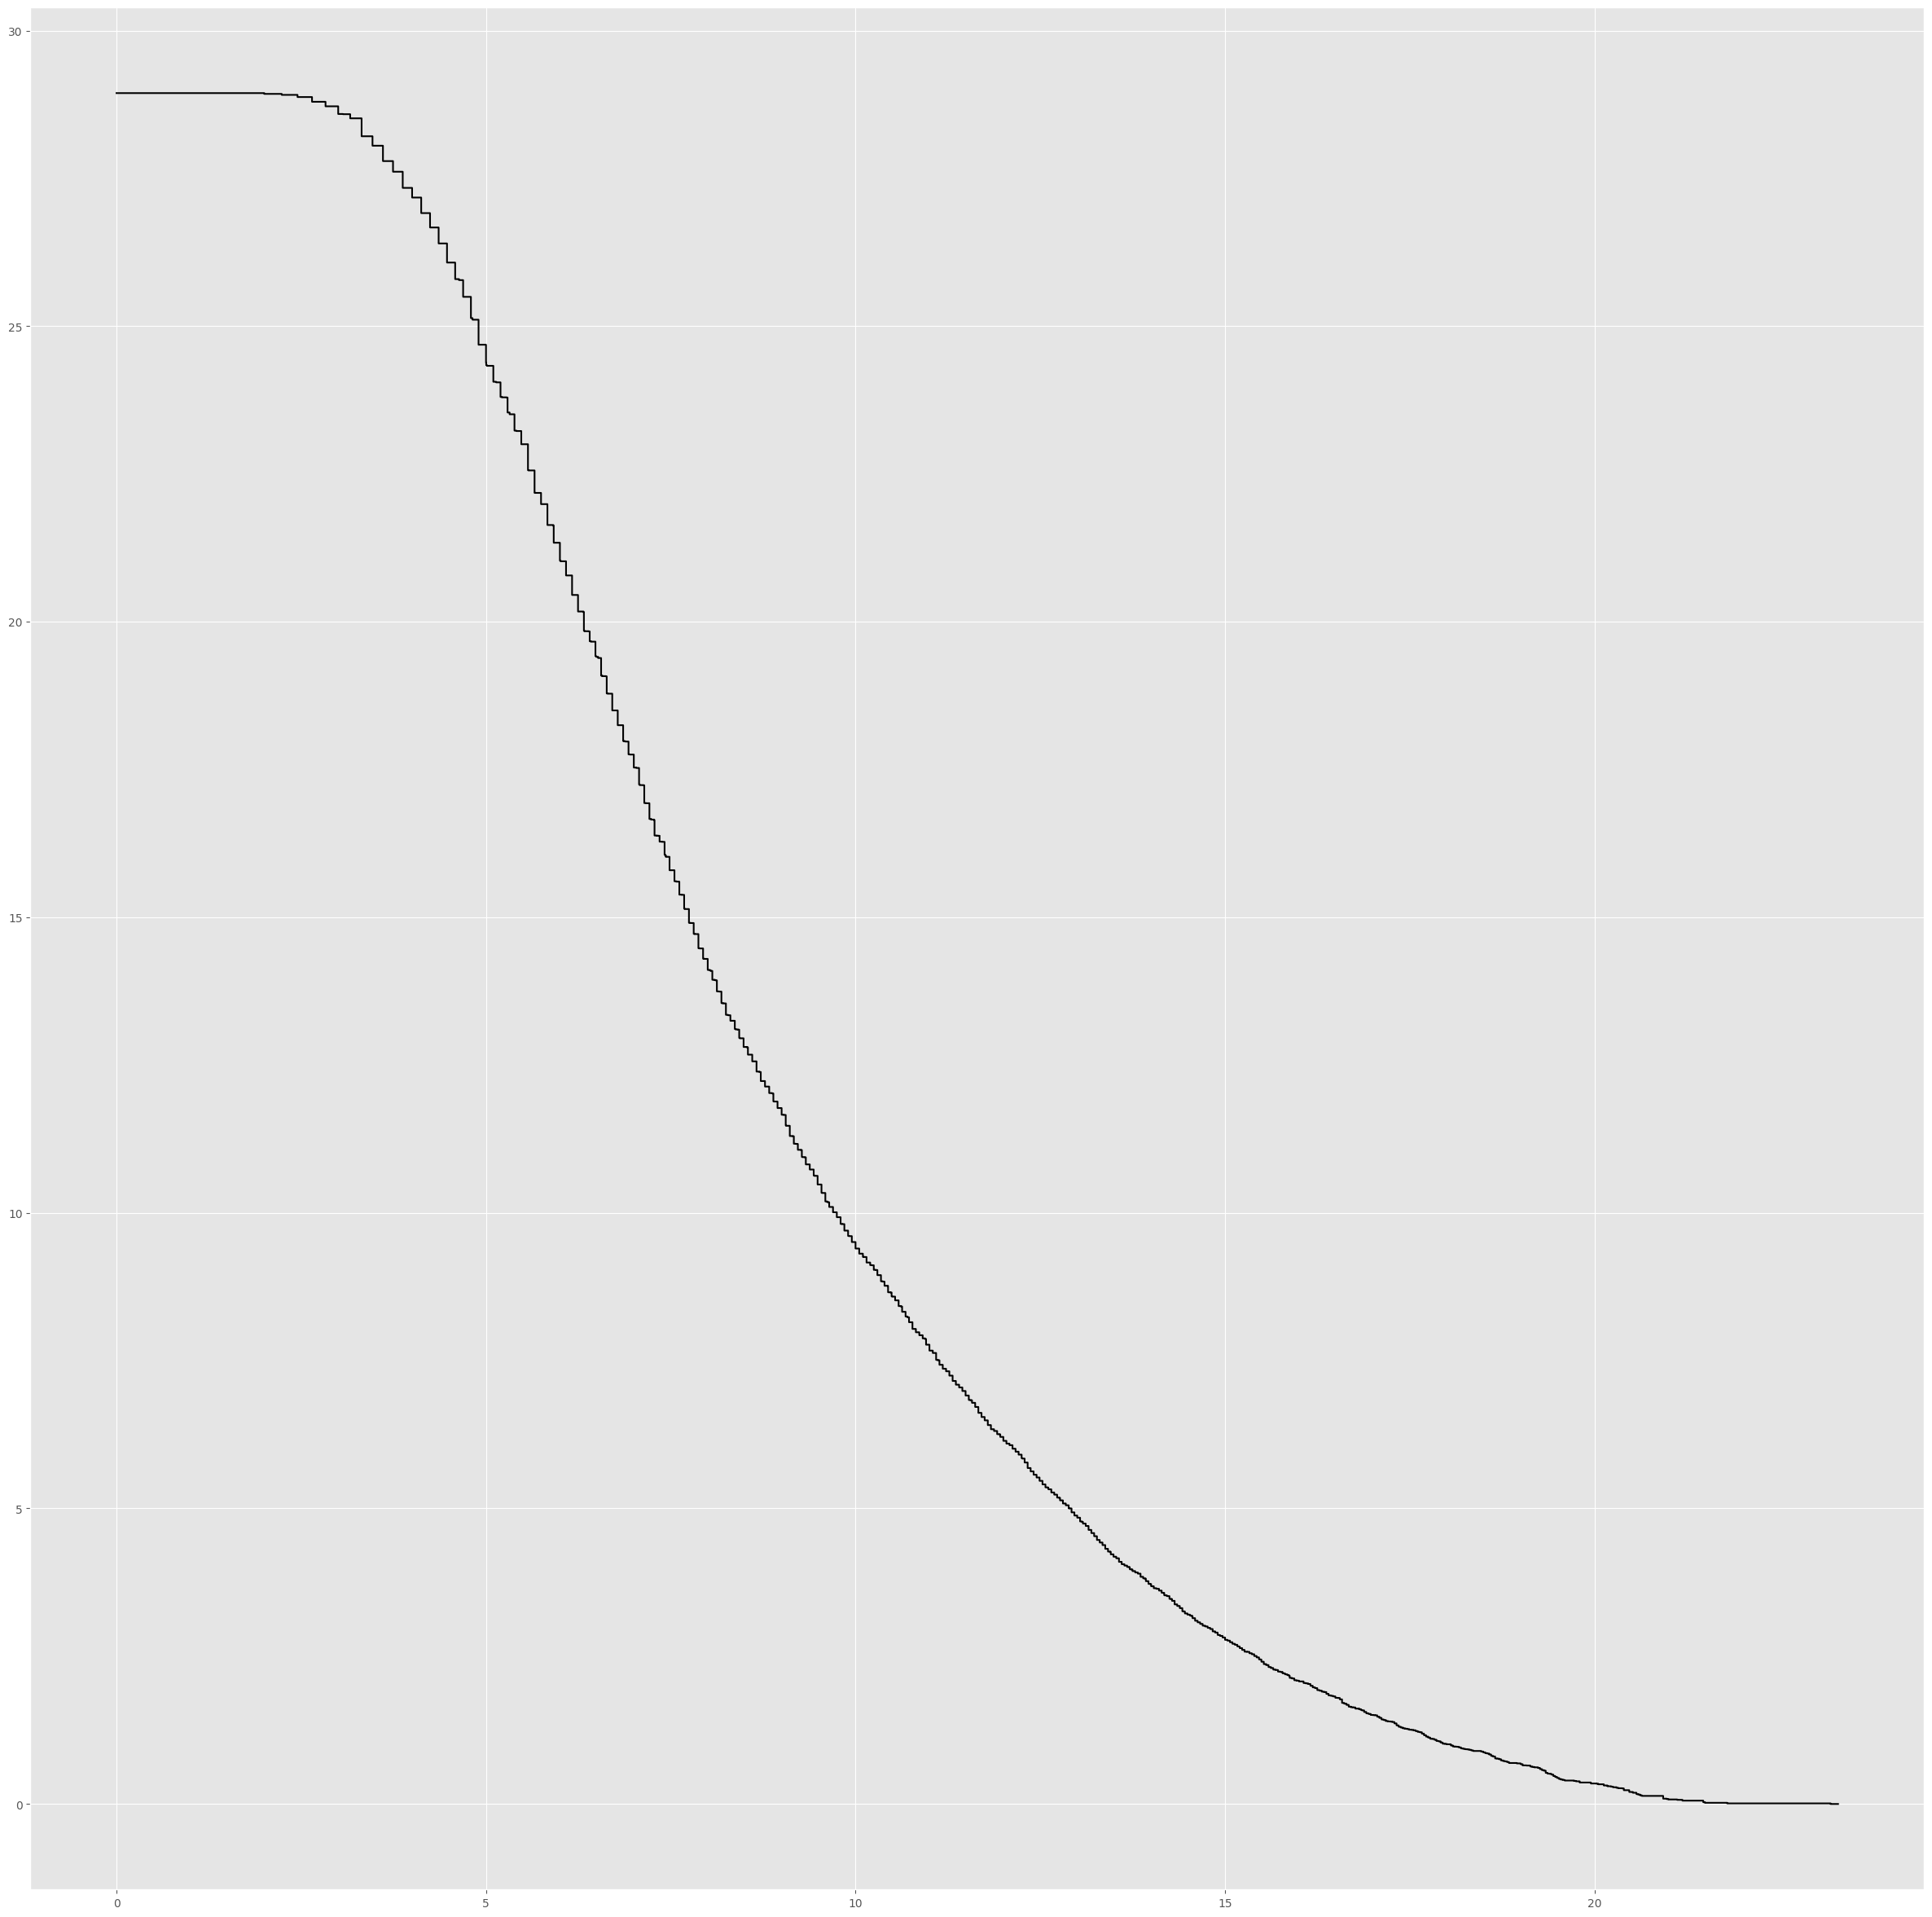

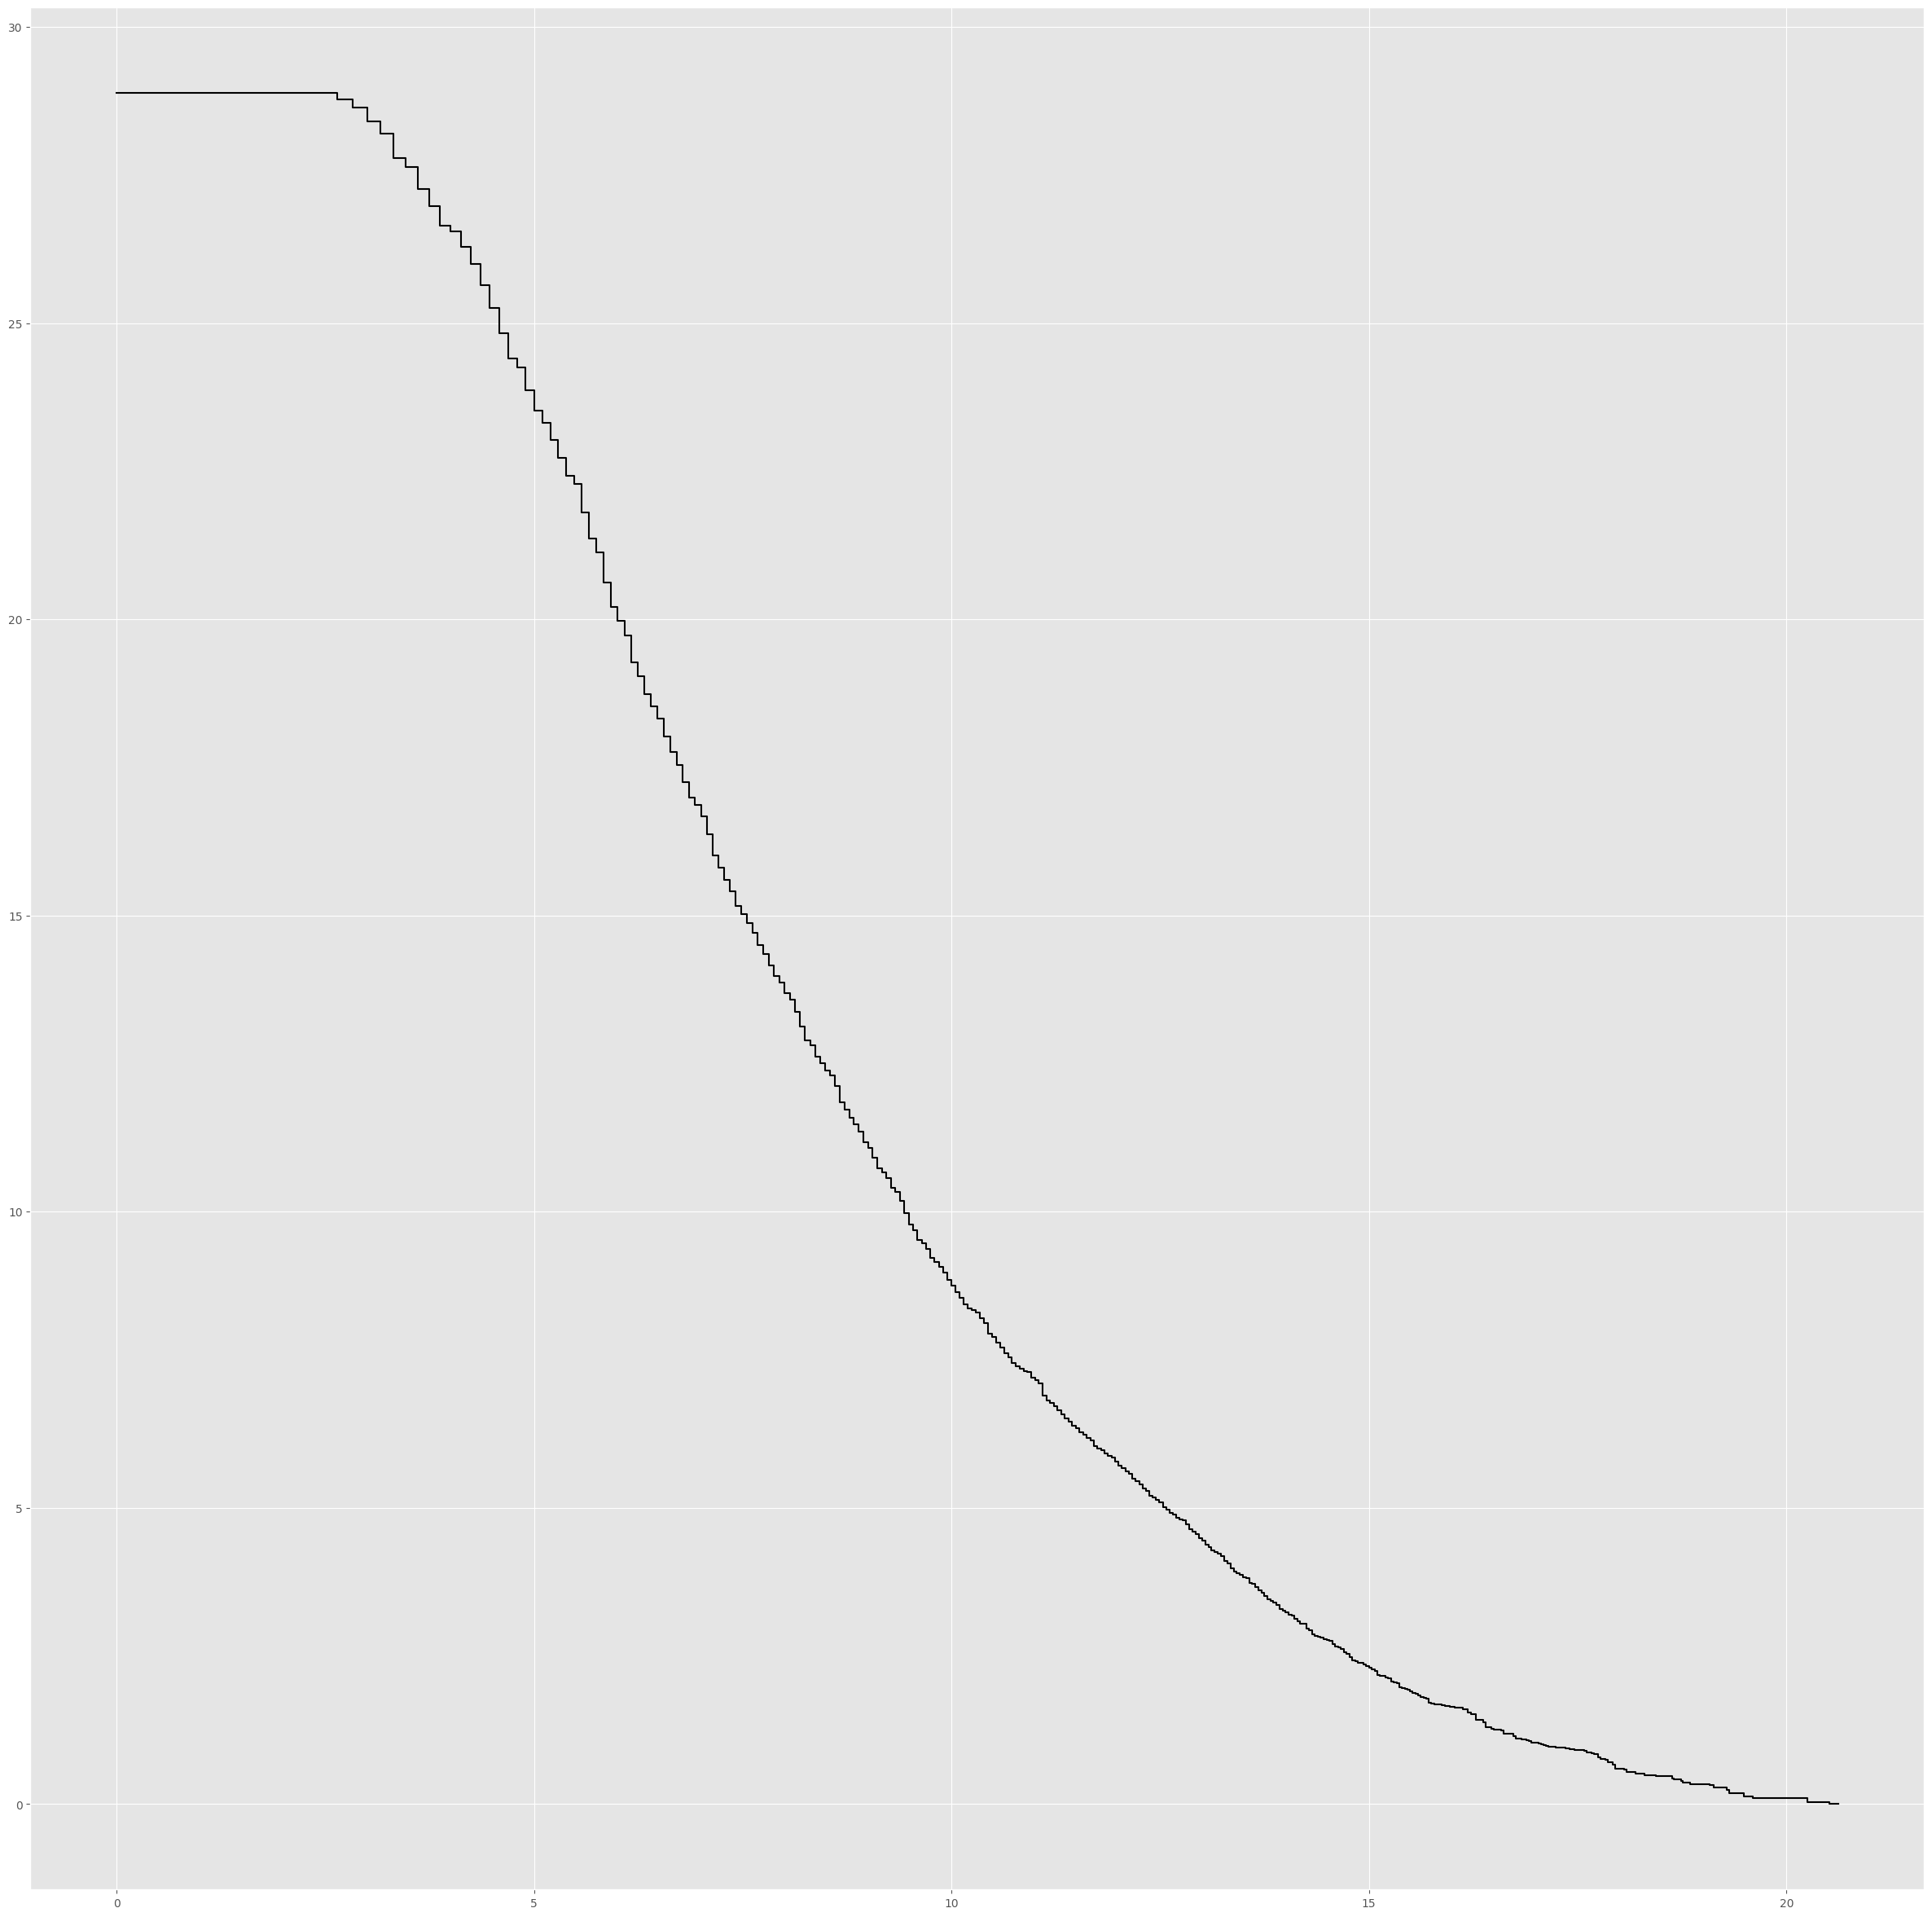

In [15]:
for k in distributions.keys():
    fig = plt.figure(k,figsize=(30,30))
    i = 0
    for f in h0_sr[k]:
        if classification[i] ==2:
            color = "black"
        else:
            color = "red"
        f.plot(color = color)
        i += 1


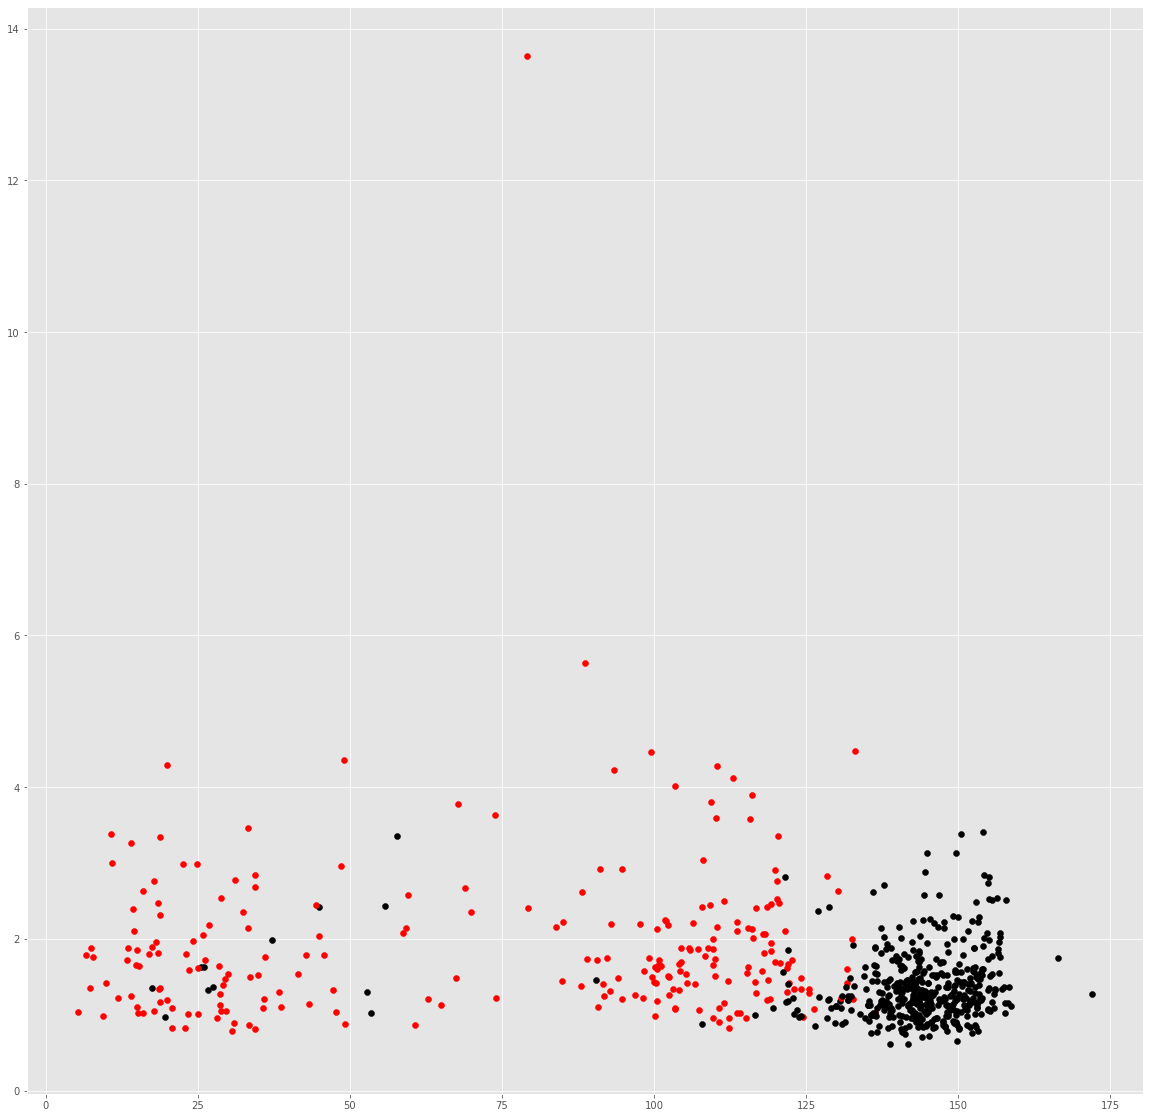

In [84]:
w = []
i = 0
points = []
while i < len(h0_sr["10_25"]):
    x = h0_sr["0_15"][i].lp_distance( h0_sr["10_25"][i])
    if x > 125:
        w.append(i)
    y = h0_sr["10_25"][i].lp_distance( h0_sr["10_30"][i])
    points.append([x,y])
    i += 1
i = 0
plt.figure(figsize=(20,20))
while i < len(points):
    if classification[i] ==2:
        color = "black"
    else:
        color = "red"
    plt.scatter(points[i][0],points[i][1], color=color)
    i += 1
    


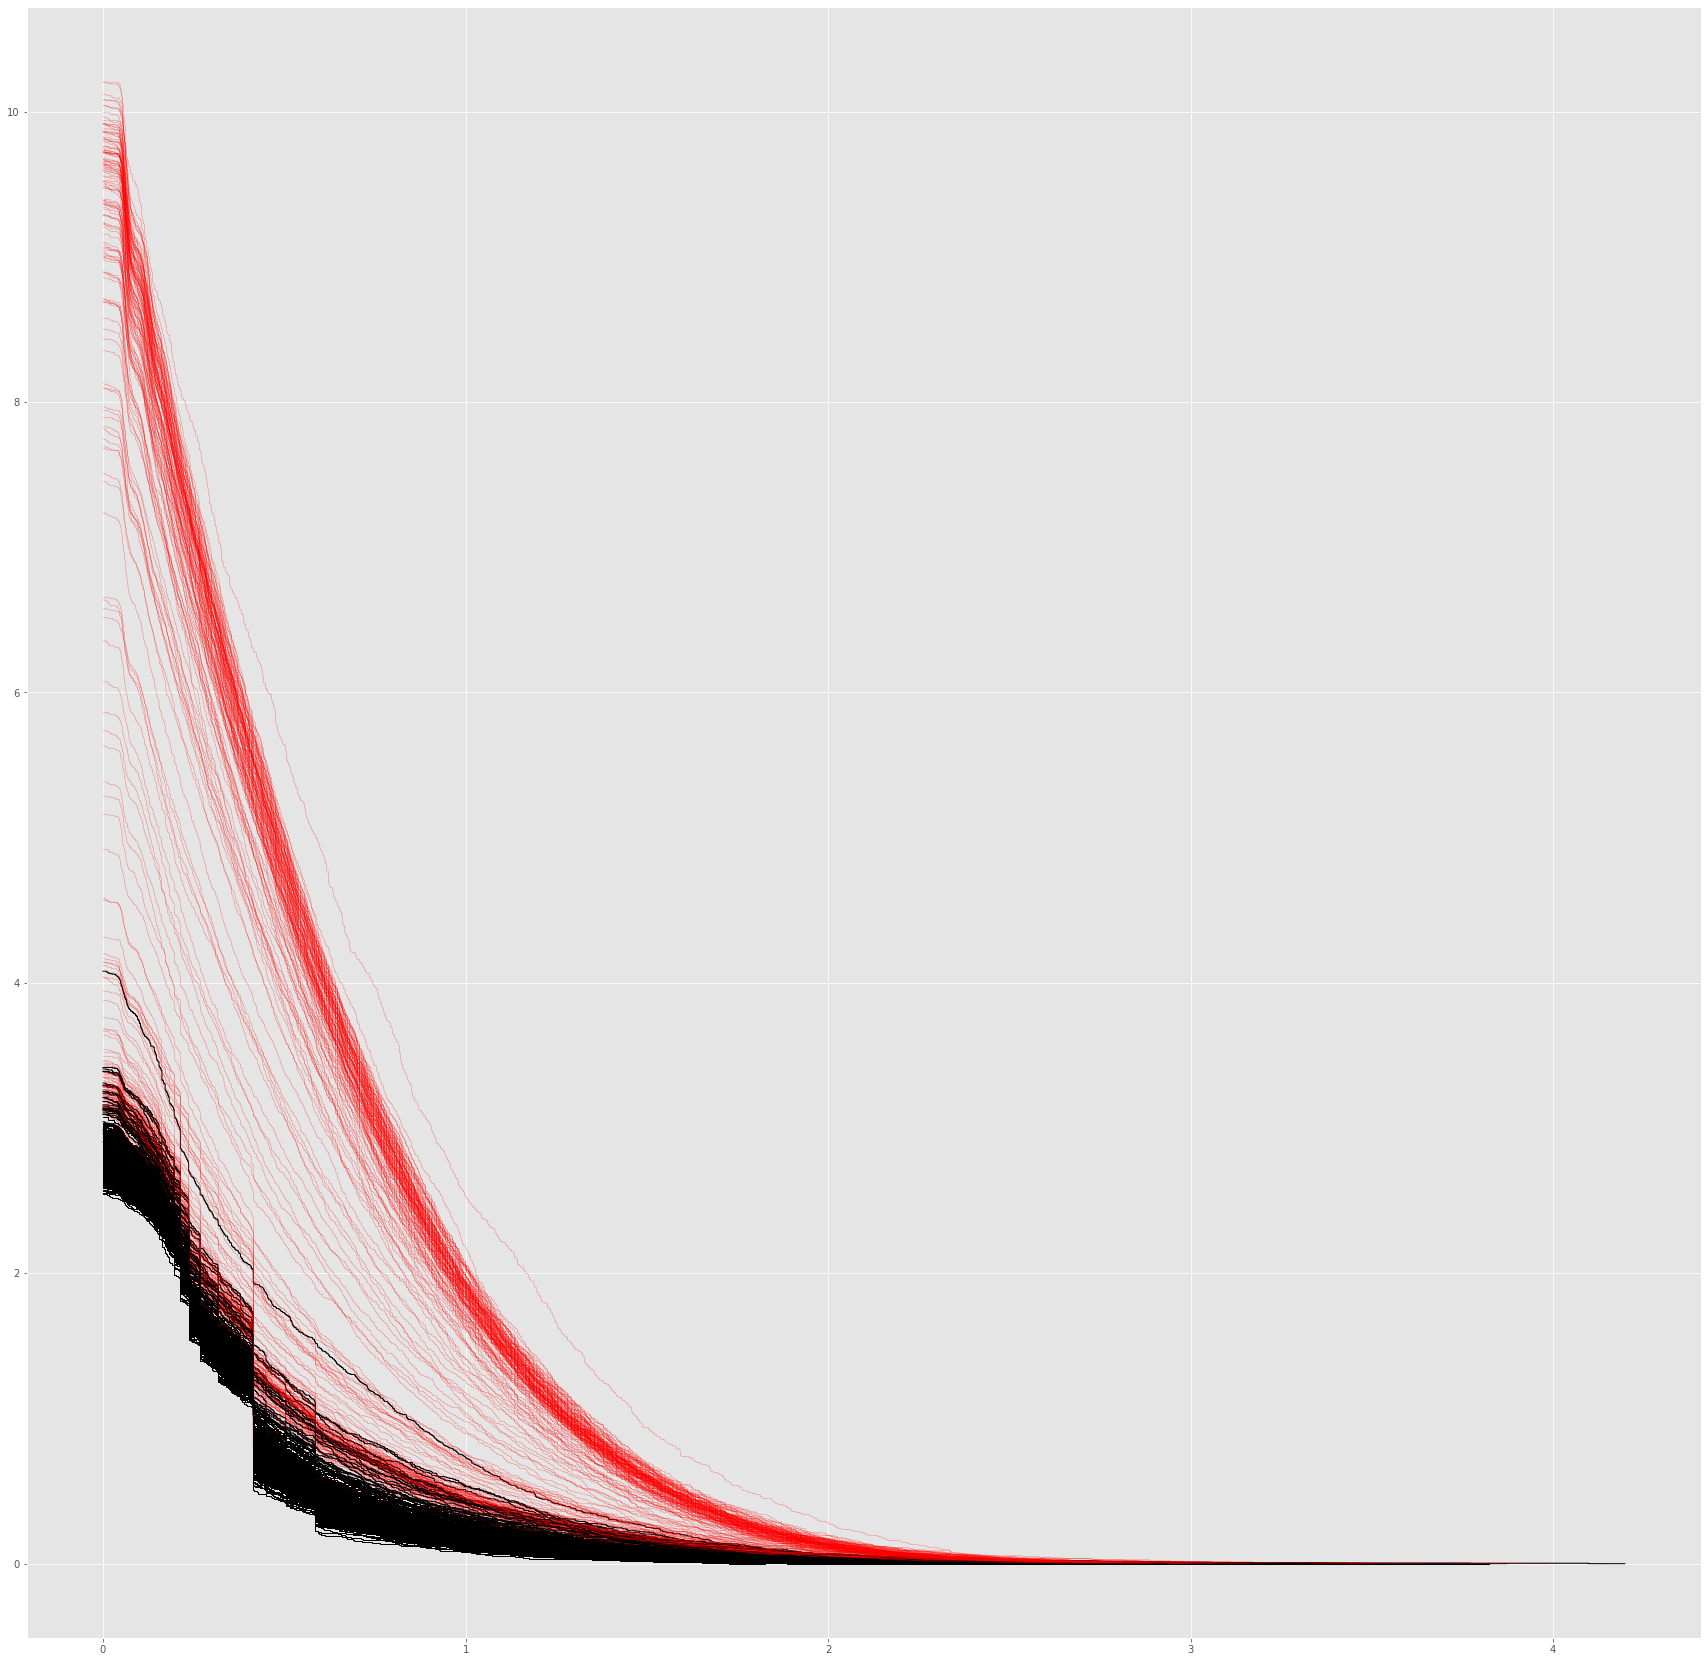

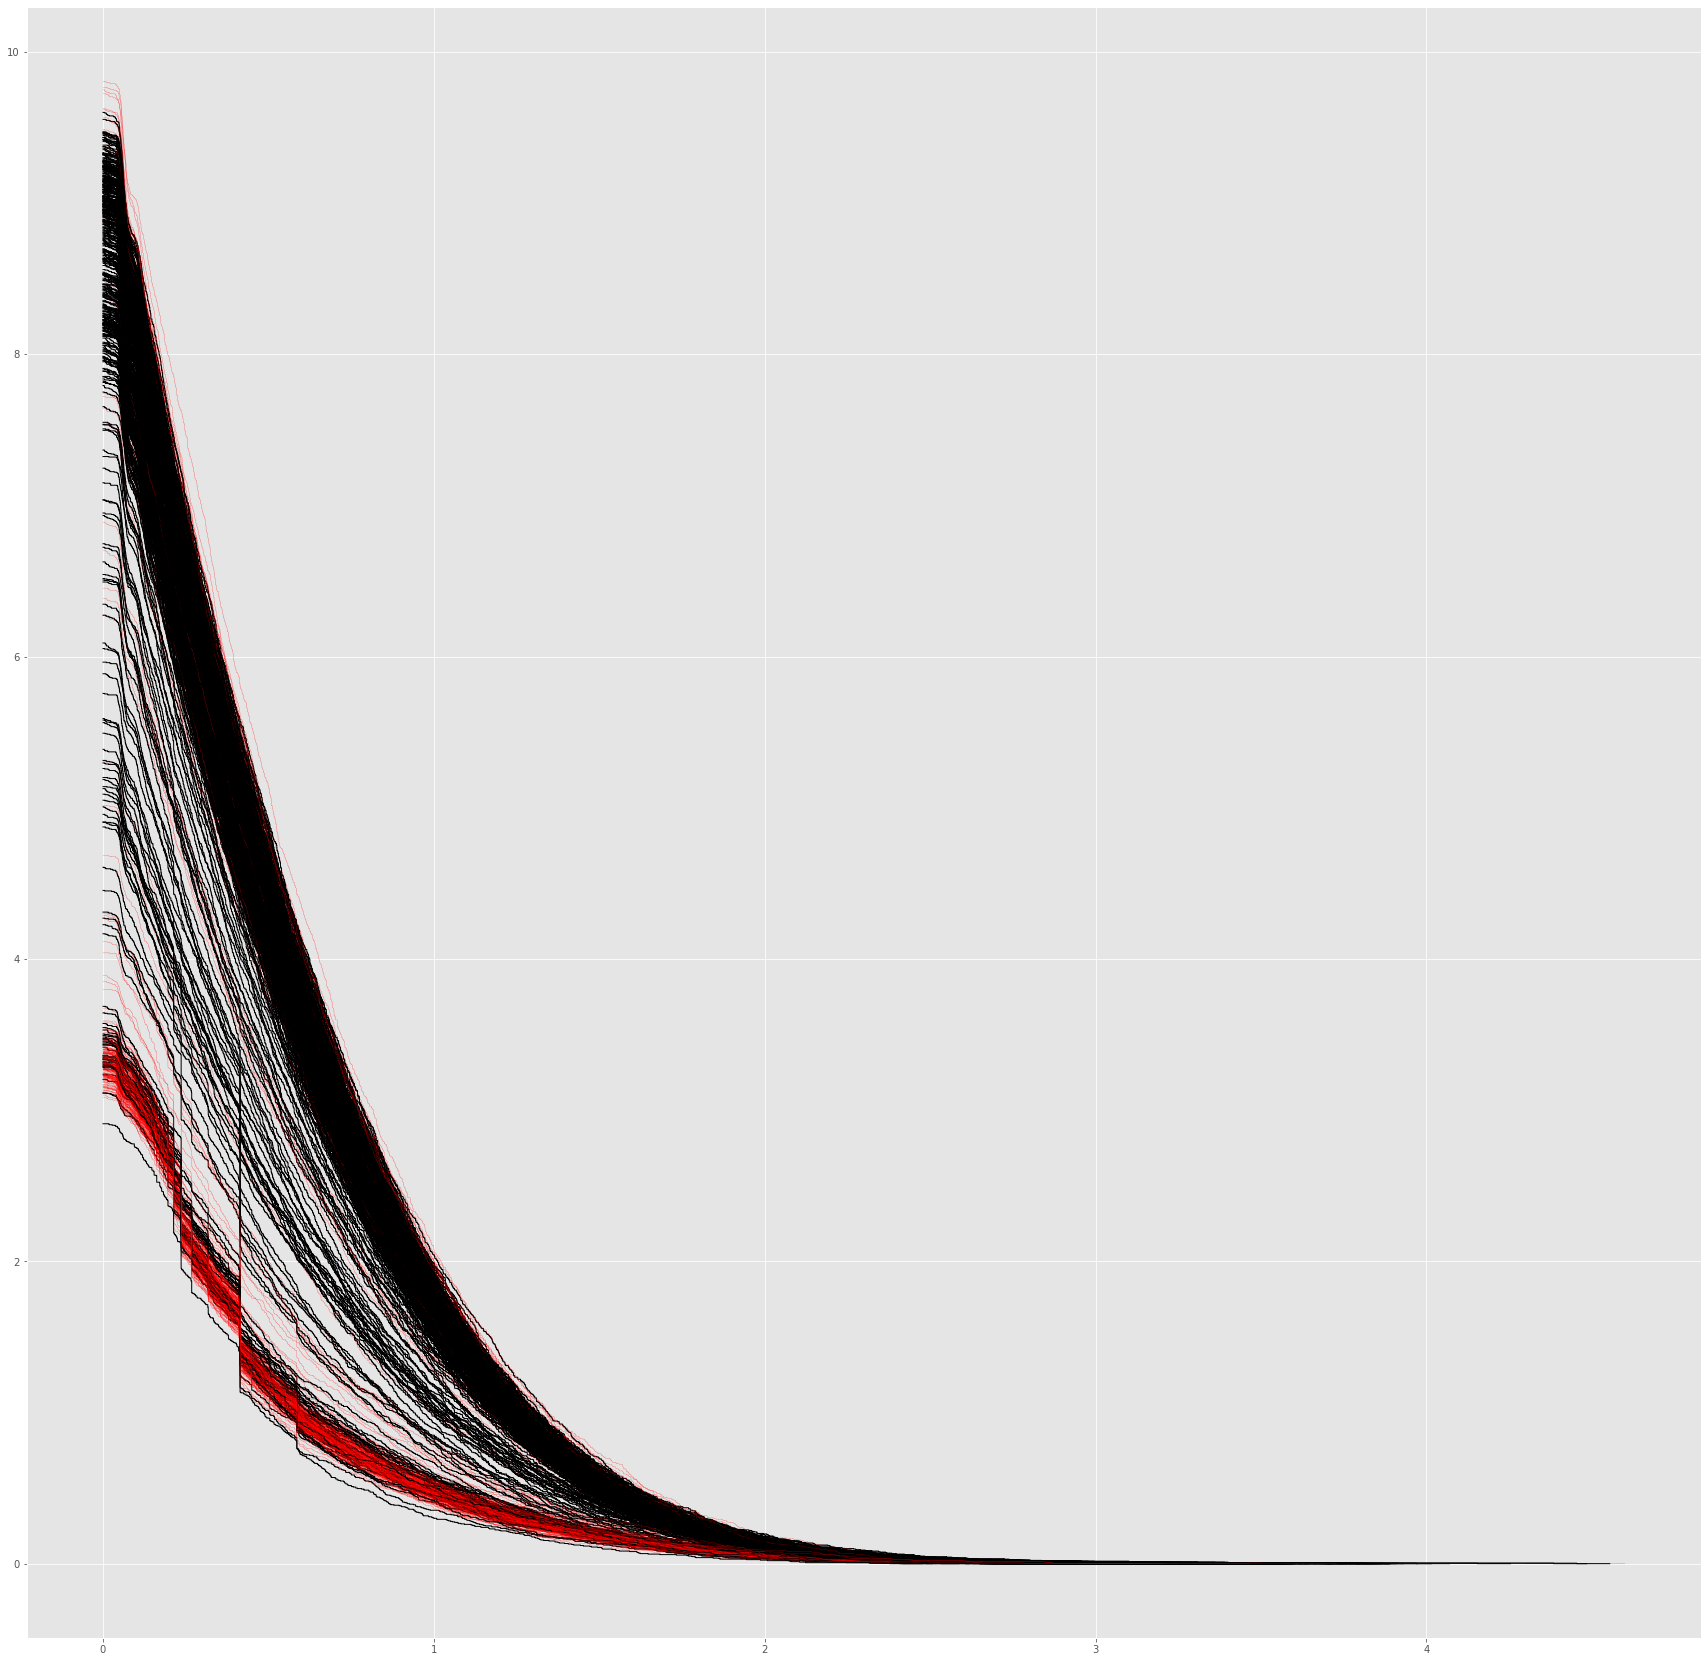

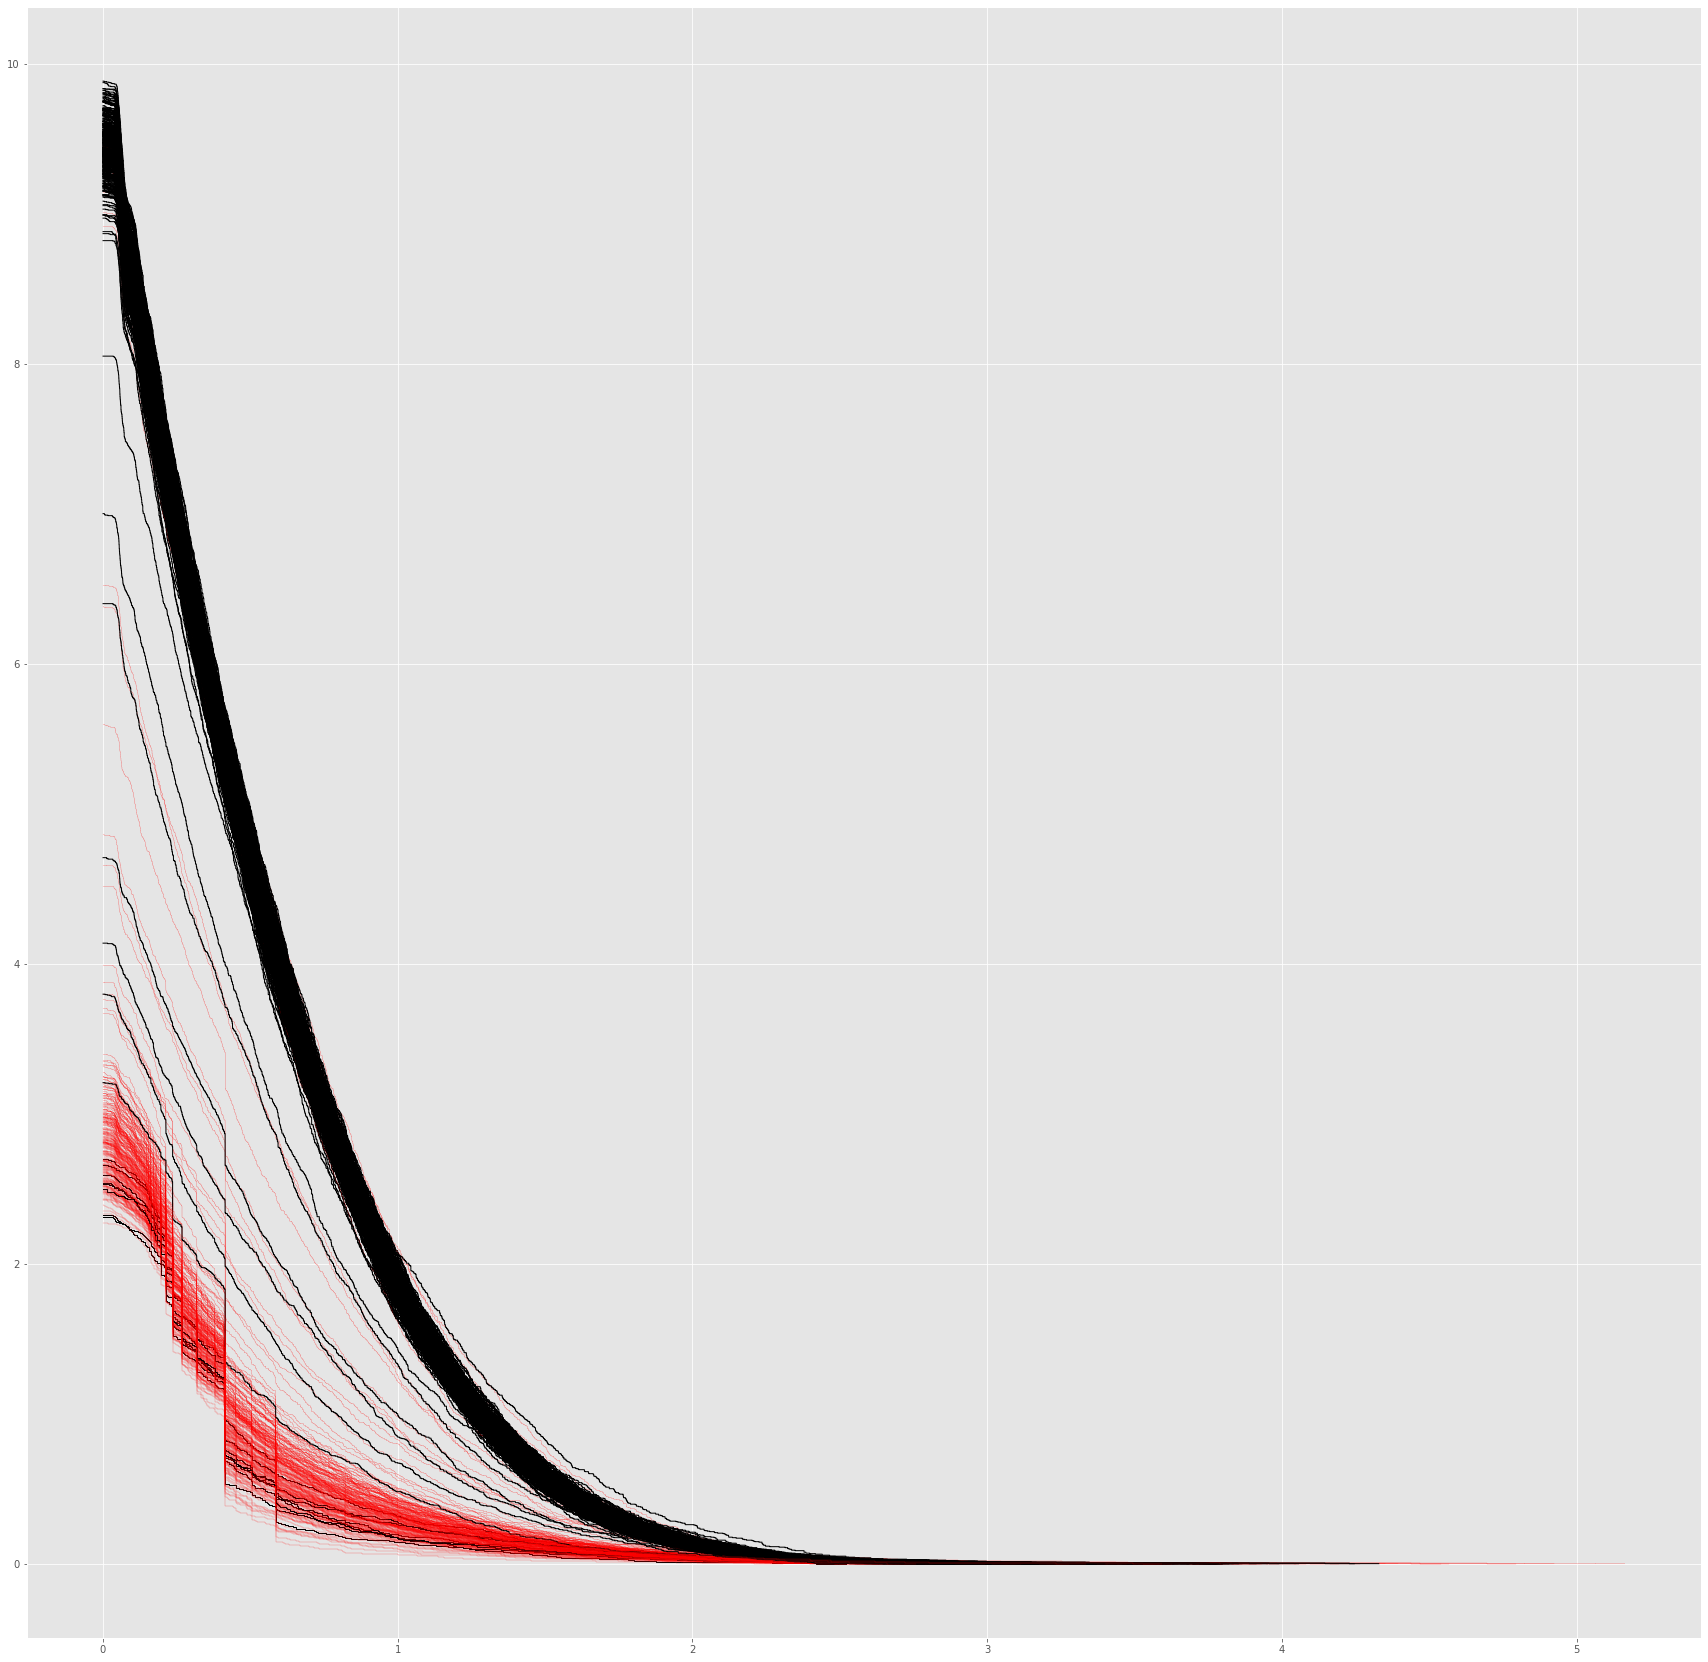

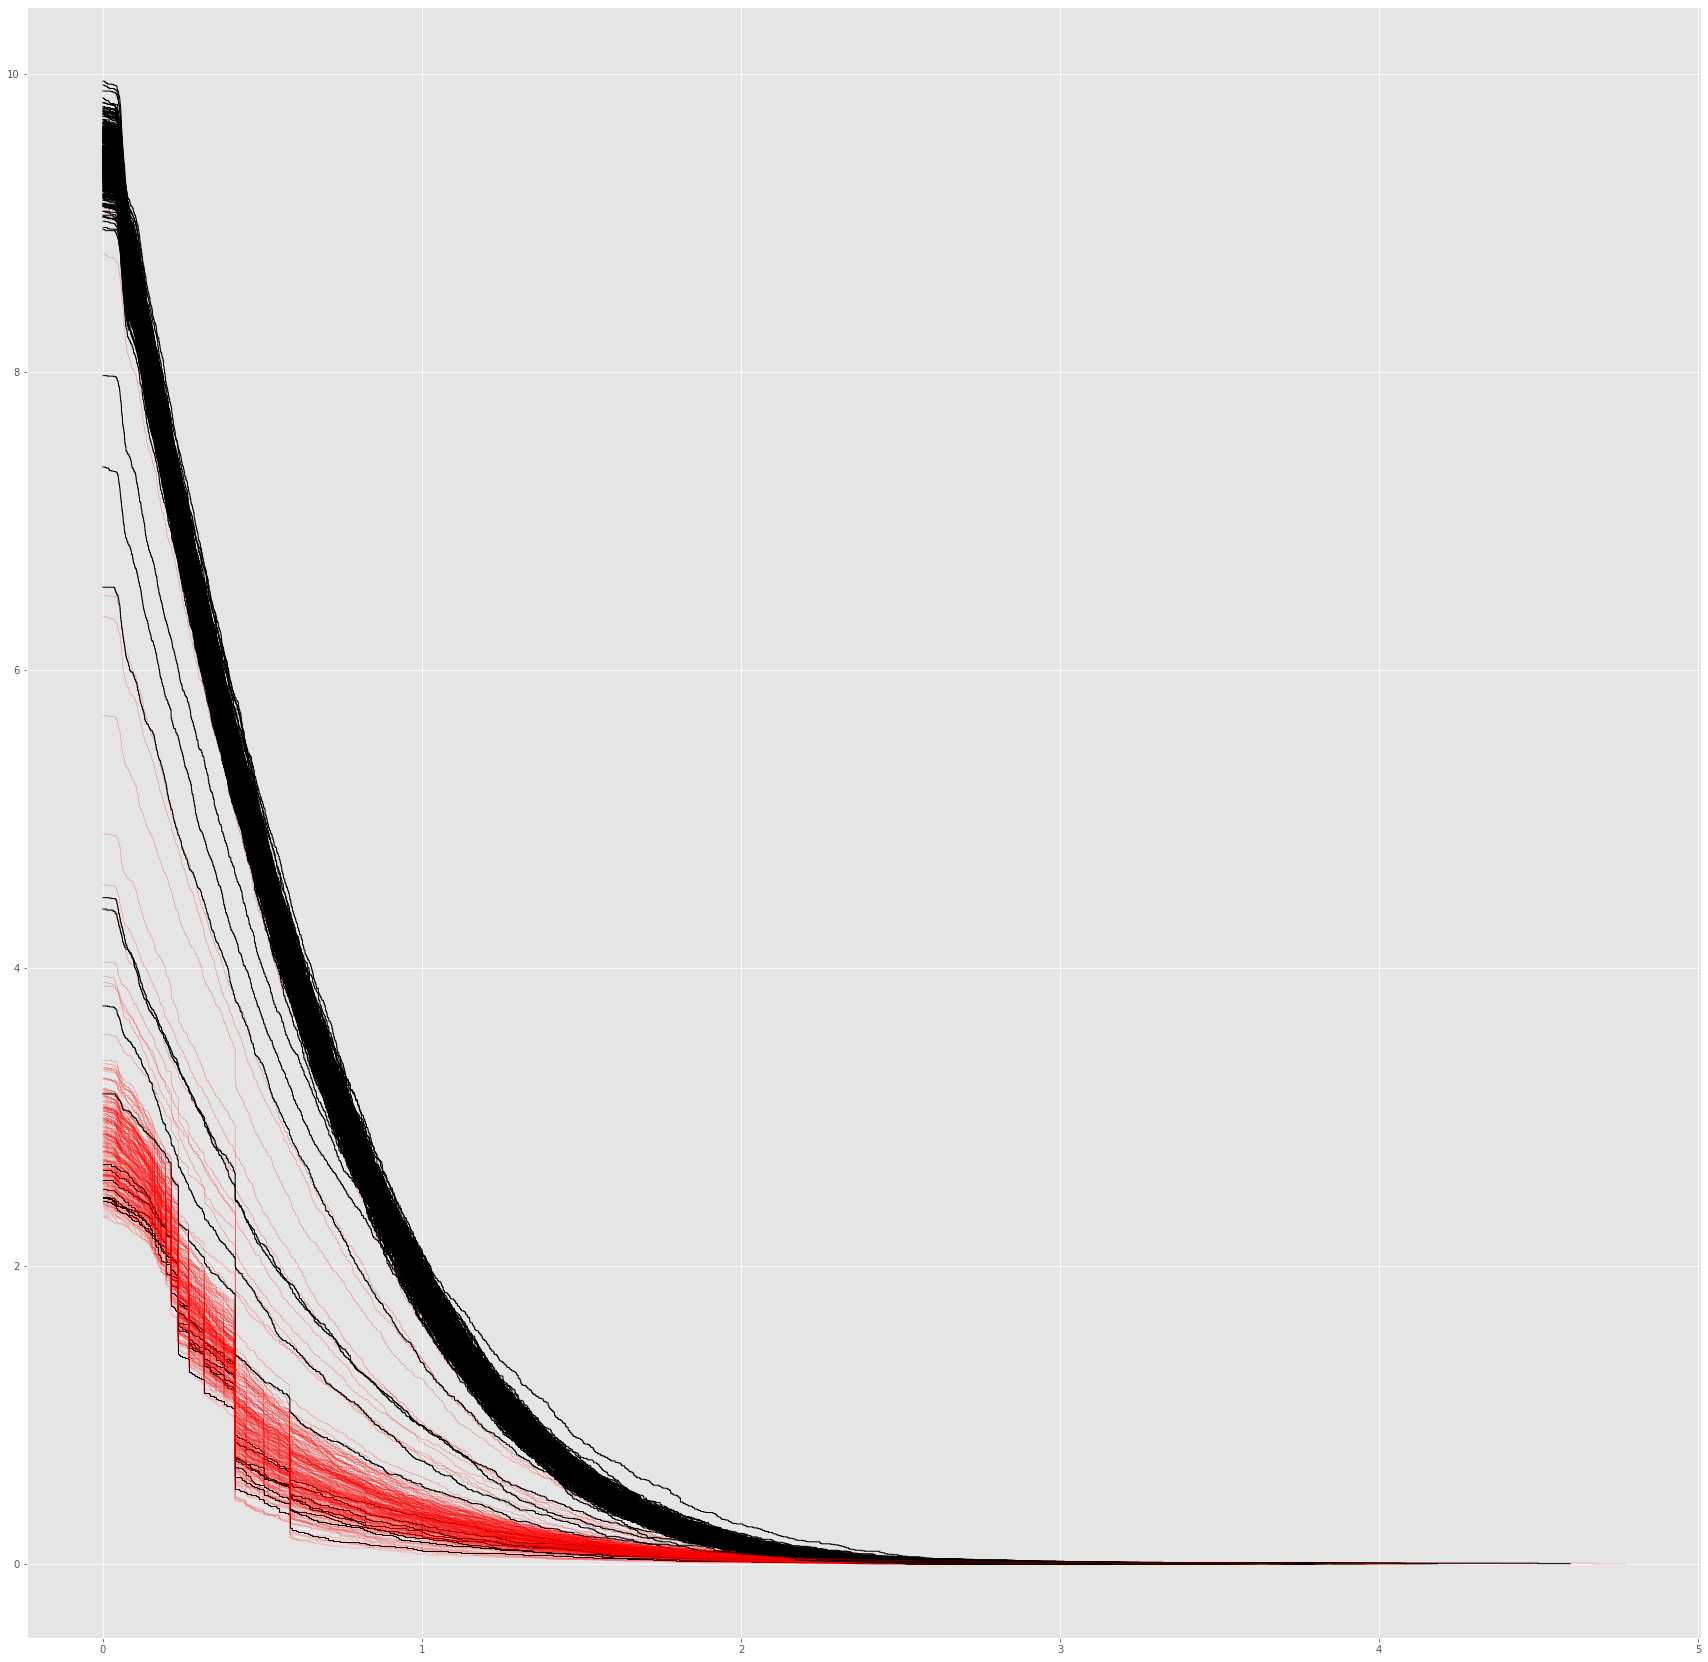

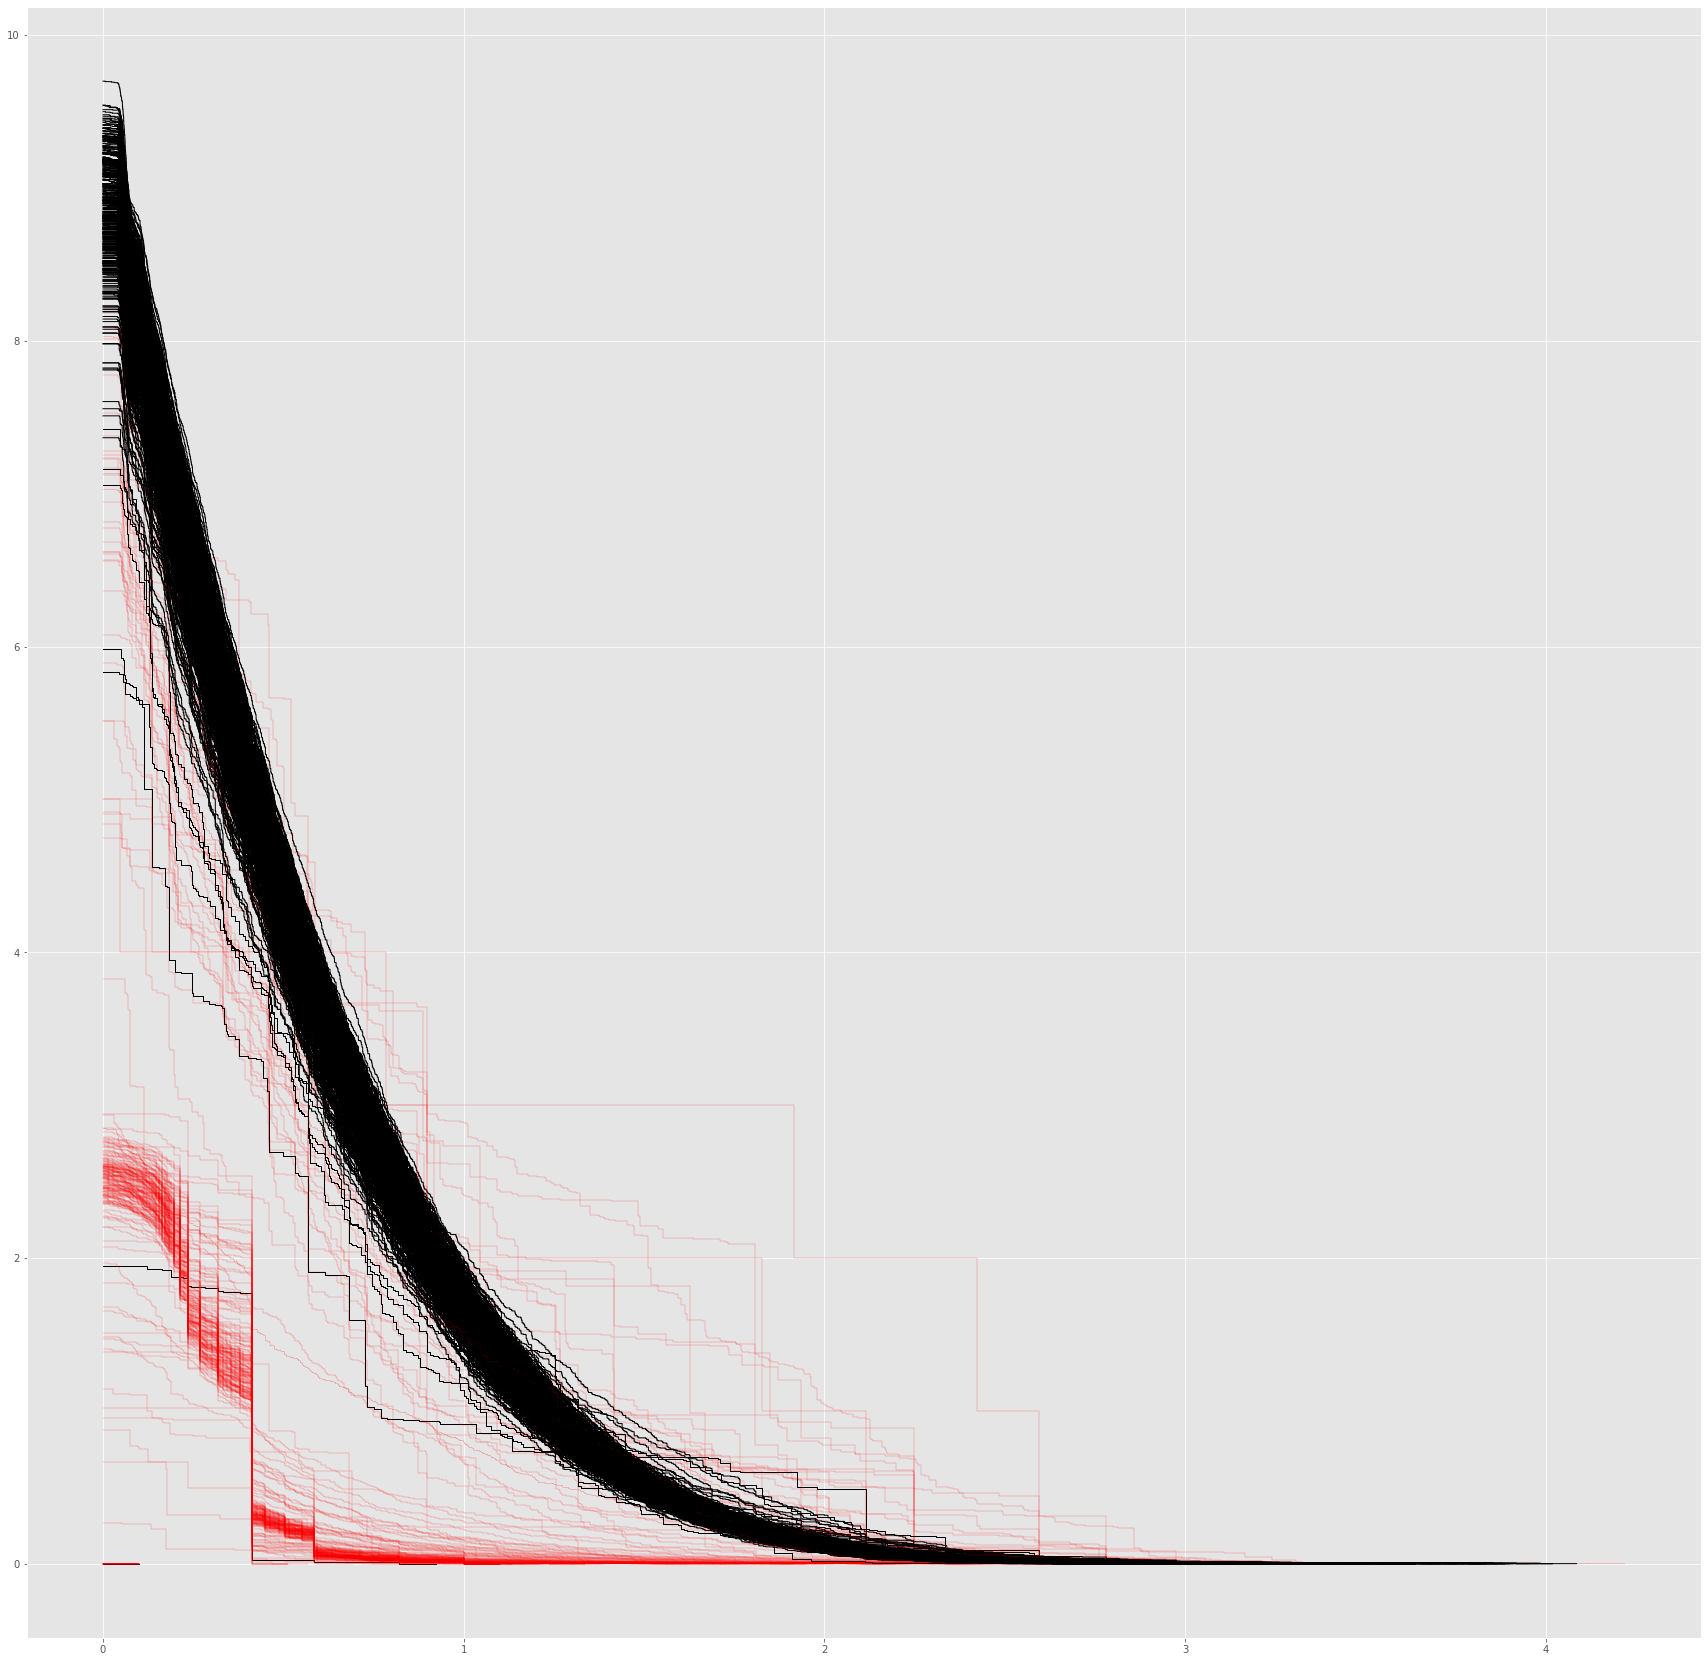

In [86]:
for k in distributions.keys():
    fig = plt.figure(k,figsize=(30,30))
    i = 0
    for f in h1_sr[k]:
        if classification[i] ==2:
            color = "black"
            linewidth = 1
        else:
            color = "red"
            linewidth=0.2
        f.plot(color = color, linewidth=linewidth)
        i += 1


In [67]:
a = 0
for i in w:
    if classification[i]!=2:
        a+= 1
print(a)
print(len(w))

14
449


In [ ]:
distributions["0_15"] = sr.get_distribution(name="uniform", interval=[0,15])
distributions["5_20"] = sr.get_distribution(name="uniform", interval=[5,20])
distributions["10_25"] = sr.get_distribution(name="uniform", interval=[10,25])
distributions["10_30"] = sr.get_distribution(name="uniform", interval=[10,30])
distributions["15_30"]

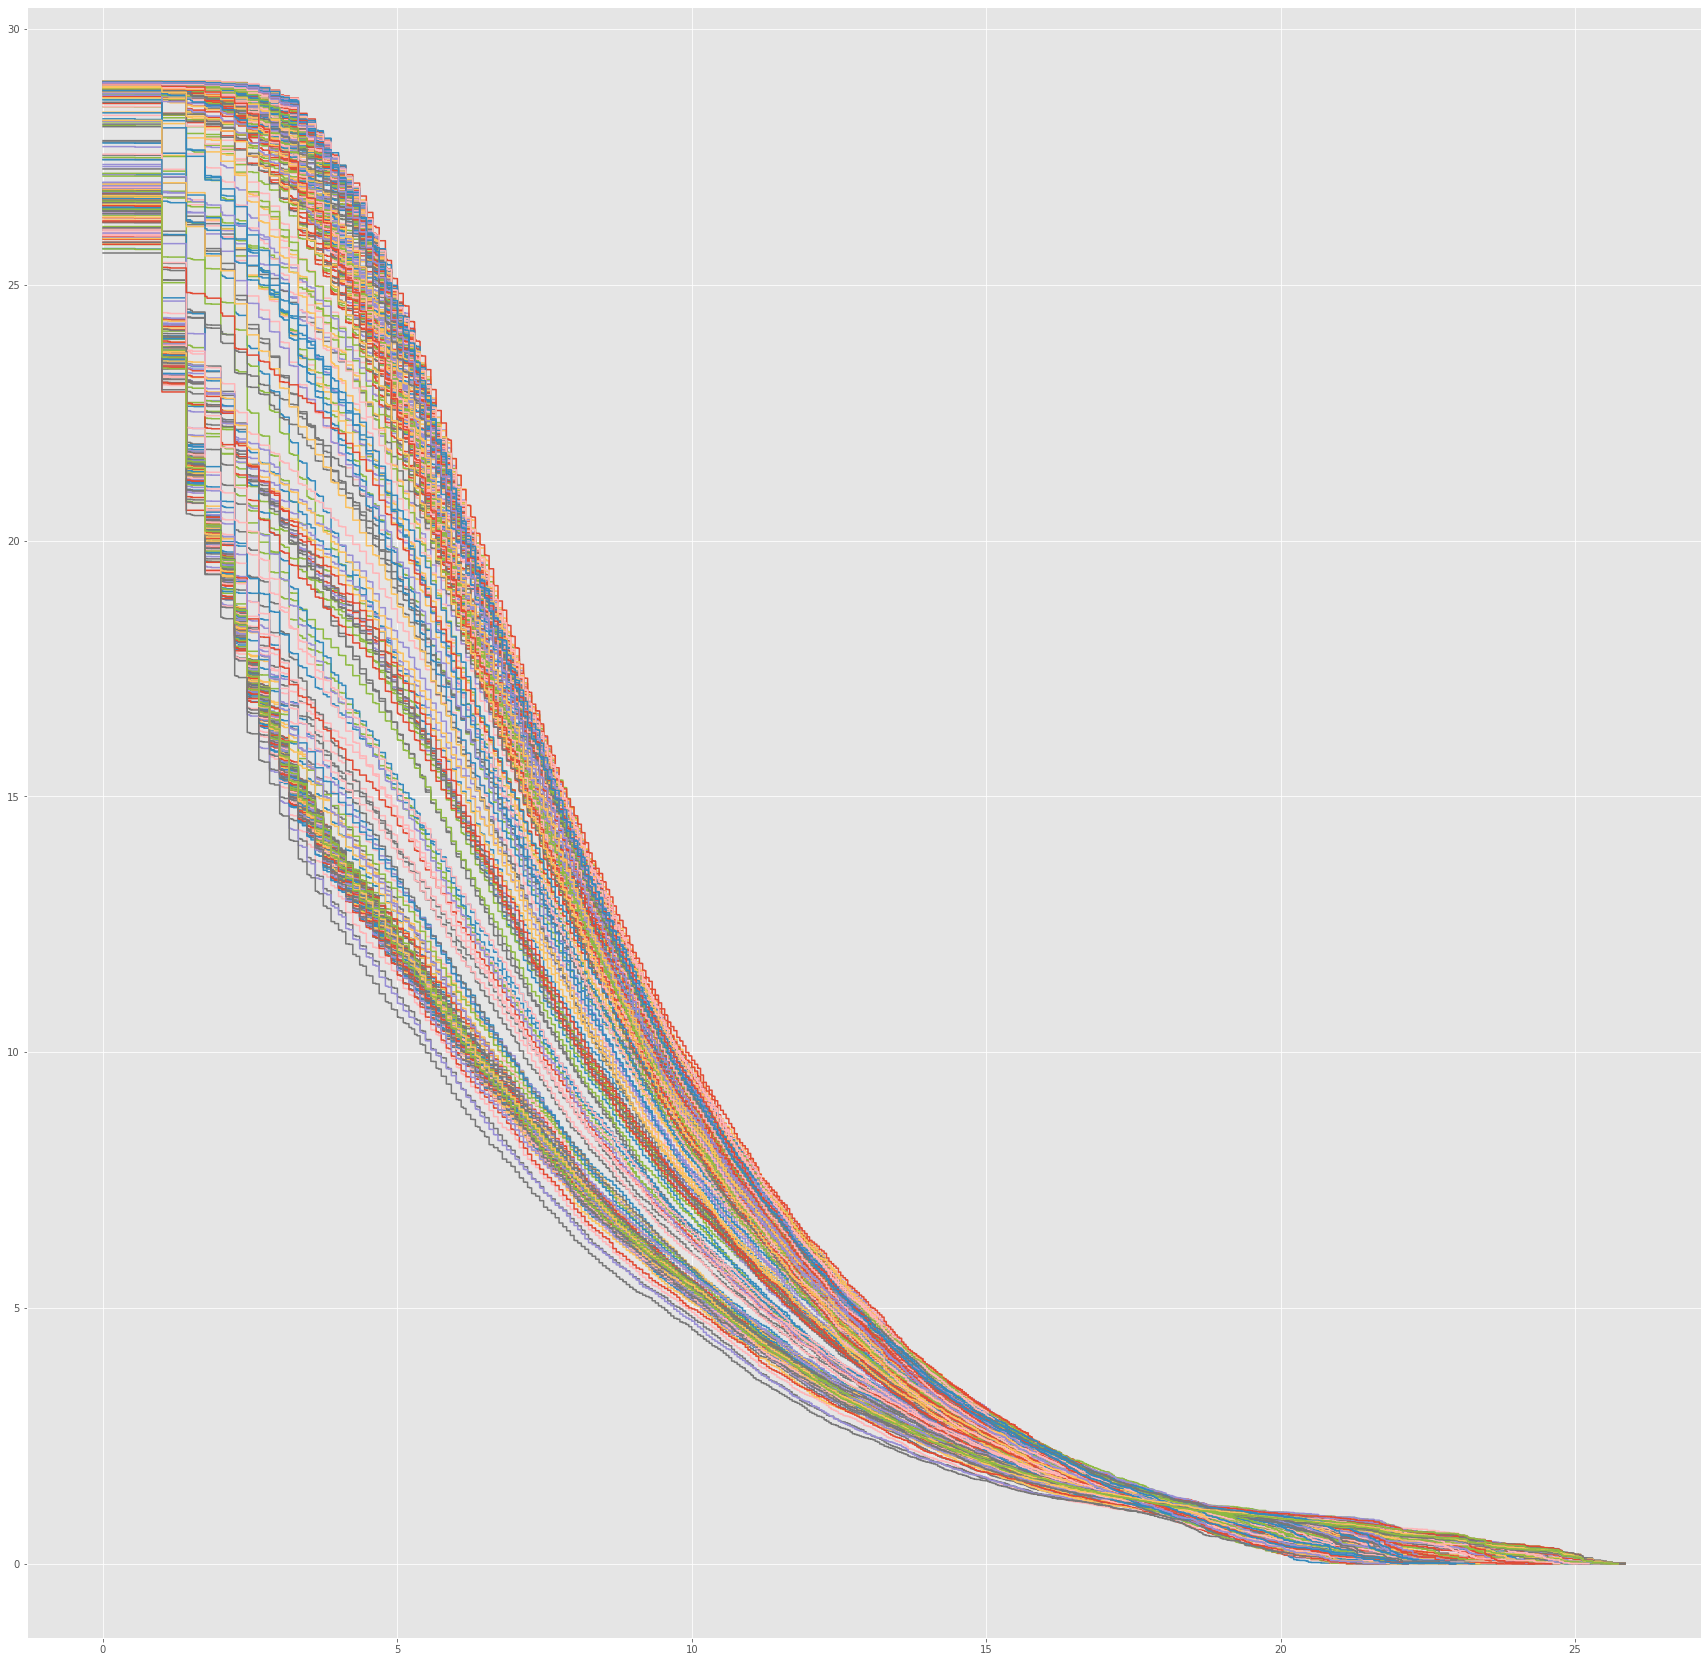

In [206]:
fig = plt.figure(figsize=(30,30))
for f in h0_sr["5_20"]:
    f.plot()

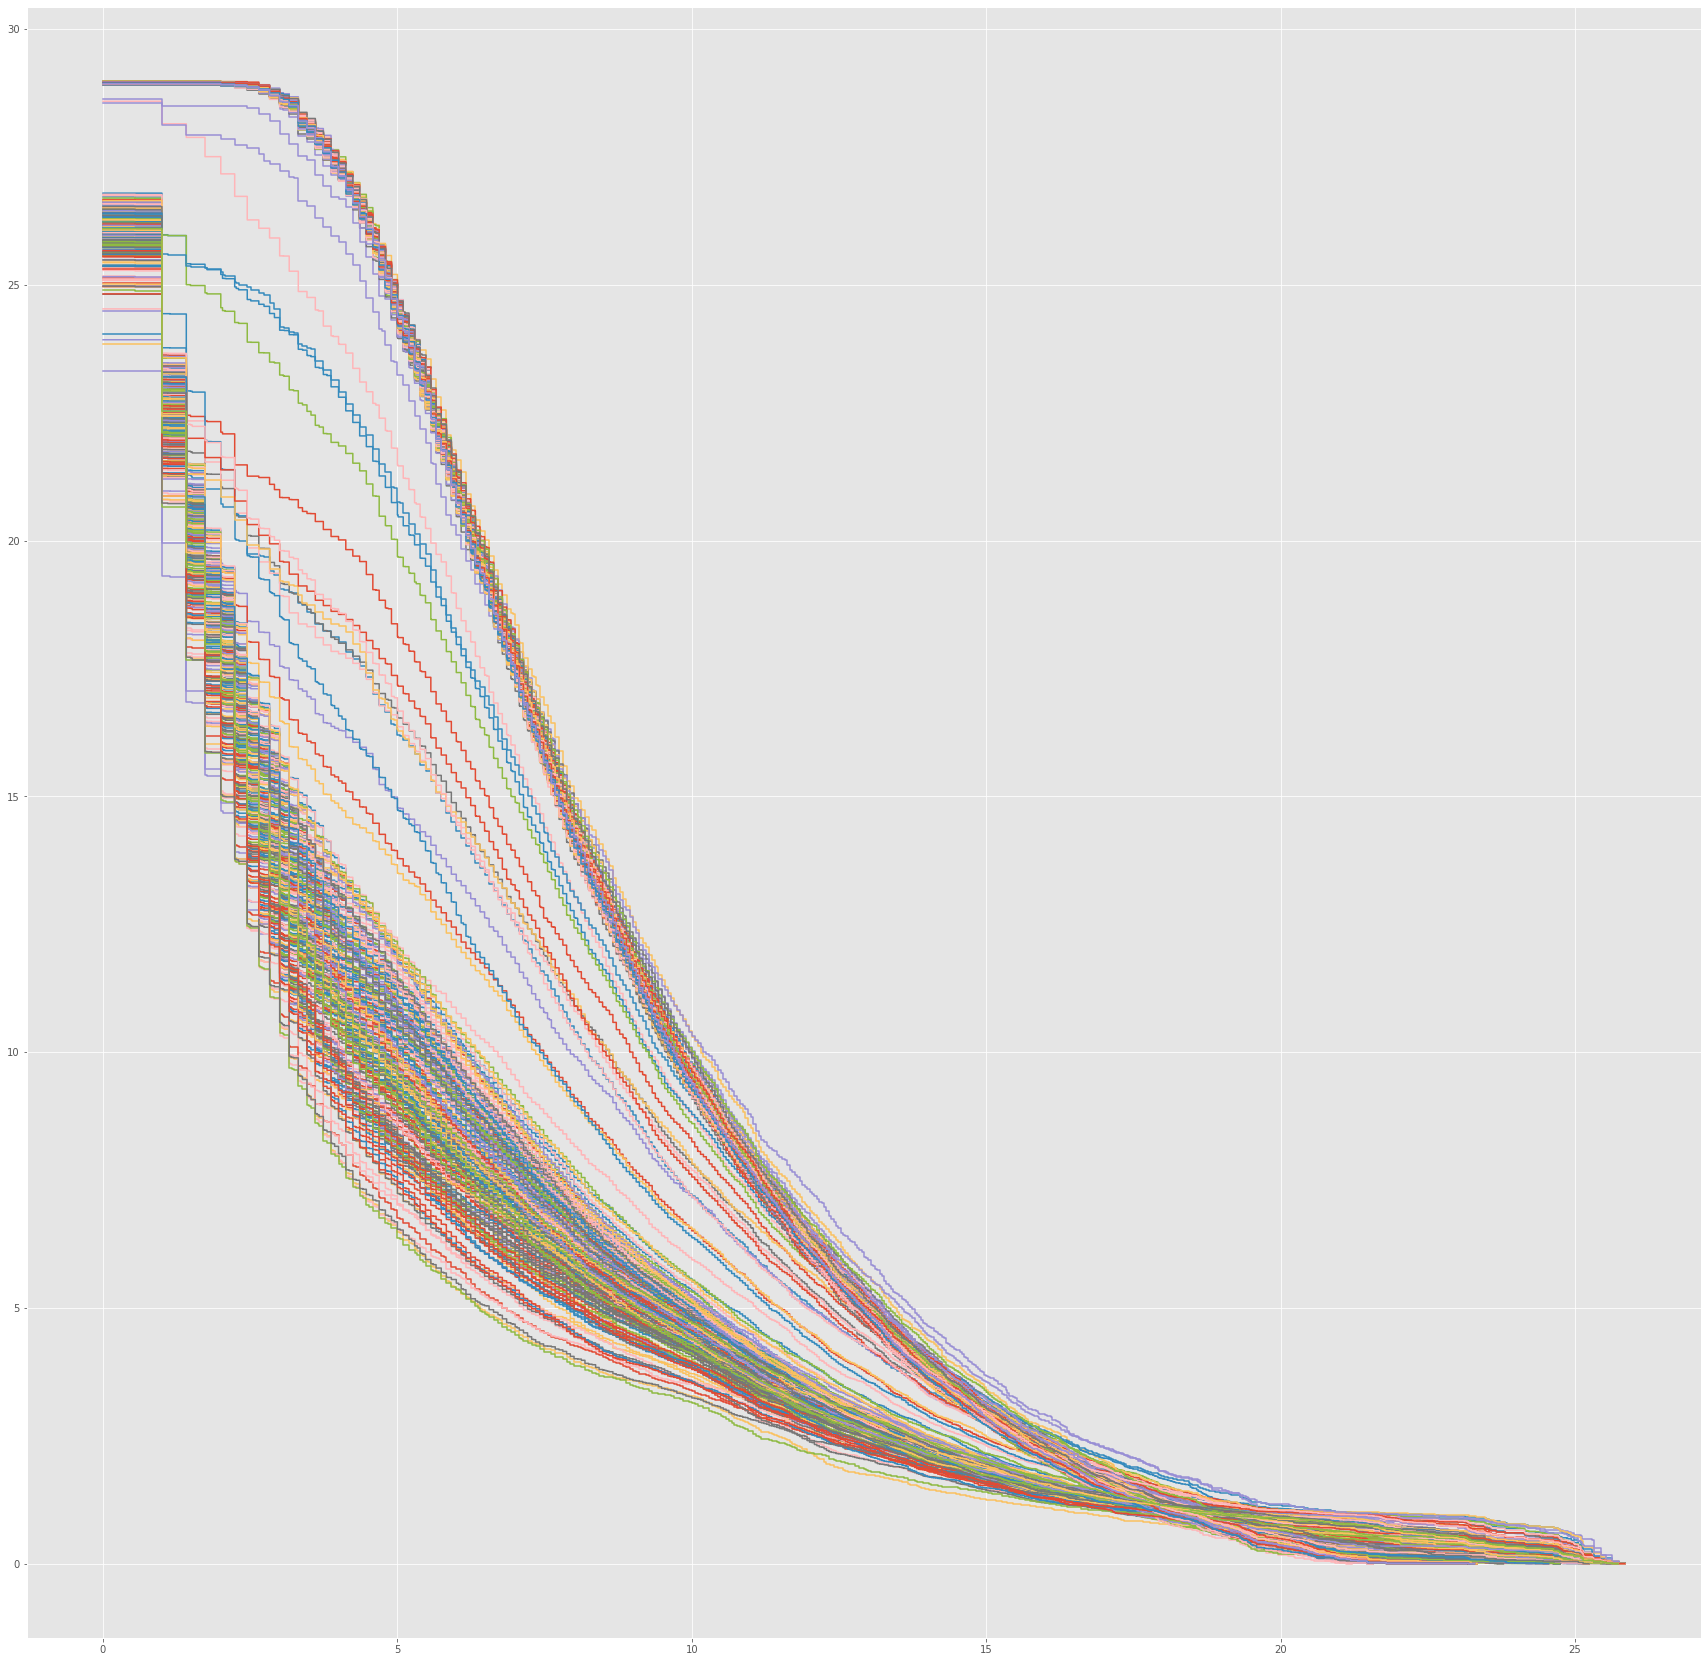

In [207]:
fig = plt.figure(figsize=(30,30))
for f in h0_sr["10_27"]:
    f.plot()